Tutorial from https://chanzuckerberg.github.io/cellxgene-census/notebooks/experimental/pytorch.html

In [1]:
import cellxgene_census
import cellxgene_census.experimental.ml as census_ml
import tiledbsoma as soma

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from torcheval.metrics.functional import multilabel_accuracy

from sklearn.metrics import f1_score


import pandas as pd
import numpy as np

import os
import time
import copy
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Plotting Function

In [3]:
def plot_results(marginalization_dict,num_epochs,save_title=None):
    fig, ax = plt.subplots(4,2,figsize=(9,12))
    
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_leaf_hist'], 
                    ax = ax[0,0],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_leaf_hist'], 
                    ax = ax[0,0],color='mediumslateblue',label='Validation')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_internal_hist'],
                   ax = ax[0,1],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_internal_hist'],
                   ax = ax[0,1],color='mediumslateblue',label='Validation')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_hist'], 
                    ax = ax[1,0],color='lightcoral')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_hist'], 
                    ax = ax[1,0],color='mediumslateblue')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_leaf_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='X',label='Train Leafs')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='o',label='Train Internal')
    #sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
    #                ax = ax[1,0],color='lightcoral',marker='v',label='Train Internal')

    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_leaf_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='X',label='Val Leafs')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='o',label='Val Internal')
    #sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
    #                ax = ax[1,1],color='mediumslateblue',marker='v',label='Val Internal')


    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_leaf'], 
                    ax = ax[2,1],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_leaf'], 
                    ax = ax[2,1],color='mediumslateblue',label='Validation')

    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_internal'], 
                    ax = ax[3,0],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_internal'], 
                    ax = ax[3,0],color='mediumslateblue',label='Validation')

    
    ax[0,0].set_xlabel('Epoch')
    ax[0,1].set_xlabel('Epoch')
    ax[1,0].set_xlabel('Epoch')
    ax[1,1].set_xlabel('Epoch')
    ax[2,0].set_xlabel('Epoch')
    ax[2,1].set_xlabel('Epoch')
    ax[3,0].set_xlabel('Epoch')


    ax[0,0].set_ylabel('Leaf Accuracy')
    ax[0,1].set_ylabel('Internal Accuracy')
    ax[1,0].set_ylabel('Total Loss')
    ax[1,1].set_ylabel('Training Loss')
    ax[2,0].set_ylabel('Validation Loss')
    ax[2,1].set_ylabel('Leaf F1 Score')
    ax[3,0].set_ylabel('Internal F1 Score')


    # set the boundary for the accuracy plots
    #ax[0,1].set_ylim((50,100))
    
    # turn off the axis for subplot 2,1
    ax[3,1].axis('off')
    
    if save_title:
        plt.savefig(save_title)



## Load the Saved Outputs from McCell_preprocessing

The preproccessing and modeling here should be run on the **same dataset**. If not, there might be differences in the ordering of cells the would nullify this model. 

- cell_parent_mask
- Mapping_dict
- Ontology_df
- Internal_values
- leaf_values


In [4]:
# Preprocessing outputs are normally stored on Turbo
os.chdir('/nfs/turbo/umms-welchjd/mccell/preprocessing_outputs')

In [5]:
# define the date in yyyy-mm-dd format
date = '2024-03-18'

In [6]:
ontology_df_name = date + '_ontology_df.csv'
ontology_df = pd.read_csv(ontology_df_name,index_col=0)


mapping_dict_name = date + '_mapping_dict_df.csv'
mapping_dict_df = pd.read_csv(mapping_dict_name,index_col=0)
mapping_dict = mapping_dict_df.T.to_dict('list')
# the values are stored as a list. convert to single value
for key, value in mapping_dict.items():
    mapping_dict[key] = value[0]

leaf_values_name = date + '_leaf_values'
internal_values_name = date + '_internal_values'
with open(leaf_values_name,'rb') as fp:
    leaf_values = pickle.load(fp)
with open(internal_values_name,'rb') as fp:
    internal_values = pickle.load(fp)


cell_parent_mask_name = date + '_cell_parent_mask.pt'
cell_parent_mask = torch.load(cell_parent_mask_name)

## Build the Experiment and the DataPipe

In [7]:
# gene and cell type info stored on Turbo
os.chdir('/nfs/turbo/umms-welchjd/mccell')

First, let's load the gene list and cell type list that we want from the Census. Then we construct the ```var_val_filter``` and ```obs_val_filter``` for querying the census.

In [8]:
# load gene list
biomart = pd.read_csv('mart_export.txt')

coding_only = biomart[biomart['Gene type'] == 'protein_coding']

gene_list = coding_only['Gene stable ID'].to_list()

var_val_filter = '''feature_id in {}'''.format(gene_list)

# load the cell type list
cell_type_list_name = 'cell_type_list.txt'
with open(cell_type_list_name,'rb') as fp:
    cell_type_list = pickle.load(fp)

obs_val_filter = '''assay == "10x 3\' v3" and is_primary_data == True and cell_type_ontology_term_id in {}'''.format(cell_type_list)


In [9]:
#organism = "Homo sapiens"
col_names = {"obs": ["cell_type_ontology_term_id"]}


In [10]:
# open the Census and create the Experiment
census = cellxgene_census.open_soma(uri = "/scratch/welchjd_root/welchjd99/fujoshua/soma")
experiment = census["census_data"]["homo_sapiens"]


In [11]:
batch_size = 256 #128 #8192 # 4096
soma_chunk_size = 50_000 #10_000

experiment_datapipe = census_ml.ExperimentDataPipe(
    experiment,
    measurement_name="RNA",
    X_name="raw",
    obs_query=soma.AxisQuery(value_filter=obs_val_filter),
    var_query=soma.AxisQuery(value_filter=var_val_filter),
    obs_column_names=["cell_type_ontology_term_id"],
    batch_size=batch_size,
    shuffle=True,
    soma_chunk_size=soma_chunk_size,
)


In [12]:
experiment_datapipe.shape

(2726029, 19966)

Split the datapipe into Train and Test splits

In [13]:
train_percent = 0.0012
val_percent = 0.0008
extra_percent = 0.999 # use this to reduce the size of the dataset

train_datapipe, val_datapipe = experiment_datapipe.random_split(weights={"train": train_percent, "val": val_percent},
                                                                seed=42)
#train_datapipe, val_datapipe, test_datapipe = experiment_datapipe.random_split(weights={"train": train_percent, "test": val_percent,'val':extra_percent},
#                                                                seed=42)


Build the dataloaders for the train and test splits. We don't use PyTorch ```DataLoader``` directly because the ```ExperimentDataPipe``` already deals with the necessary parameters. 

In [14]:
train_dataloader = census_ml.experiment_dataloader(train_datapipe)
val_dataloader = census_ml.experiment_dataloader(val_datapipe)

In [20]:
#train_dataloader.size
#print(len(train_dataloader.dataset))
train_dataloader.dataset

_IterDataPipeSerializationWrapper

In [28]:
start_batch = time.time()
for batch in train_dataloader:
    print('running time', (time.time()-start_batch))
    break

running time 395.4807653427124


In [29]:
start_batch = time.time()
for batch in val_dataloader:
    print('running time', (time.time()-start_batch))
    break

running time 353.2778468132019


## Build Neural Network Classifier

First, we need to select and define the input and output dimensions from the data. The number of neurons for the hidden nodes is defined manually.

In [15]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = experiment_datapipe.shape[1]#X_train.size(dim=1) #adata.X.shape[1] 

# number of neurons for hidden layers
hidden_layer_1 = 256
hidden_layer_2 = 128

# number of leaf classes (unique of y that are greater than or equal to 0)
output_dim = len(leaf_values) #torch.unique(y_train[y_train >= 0]).size(dim=0) #labels['encoded_labels'].nunique()

print(input_dim,hidden_layer_1,hidden_layer_2,output_dim)

19966 256 128 88


In [16]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layer_1)
        self.linear2 = nn.Linear(hidden_layer_1,hidden_layer_2)
        self.linear3 = nn.Linear(hidden_layer_2,output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_layer_1)
        self.bn2 = nn.BatchNorm1d(hidden_layer_2)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.softmax(x,dim=1)
        return x
    
    def get_last_layer(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

## Functions for dealing with cell ontology and loss calculations

We'll need a few specific functions to process the predicted values with the structure of the Cell Ontology. We'll define these here. Full details of each function are found in each space. 

- output_probability_tensor: convolves the predicted classification outputs with the ontology hierarchy to get predicted normalized probabilities for all parent nodes
- target_probability_tensor: convolves the known target values with the ontology hierarchy to get target probabilities for all parent nodes
- build_mask_tensor_for_batch : builds a masking tensor from cell_parent_mask specific to the targets for each batch of data.

In [17]:
def transform_data(x_data):
    '''
    This function takes the input x_data, transforms the data with log(1+x) and 
    returns the transformed data
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    '''
    
    # np.log takes the natural log
    x_data.data = np.log(1+ x_data.data)

    return x_data


In [18]:
def output_probability_tensor(outputs,ontology_df):
    '''
    Function to convolve the predicted classification outputs with the ontology heirarchy to
    get predicted normalized probabilities for all parents. 
    Precursur to loss calculation
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    sum_probability_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
        
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.FloatTensor(ontology_df.values)
    ontology_tensor = ontology_tensor.to(device)
        
    # convolve the ontology tensor with the predicted outputs
    # ontology tensor is shape ij, where i = parent IDs, j = probability for leaf IDs
    # output tensor is shape kj, where k = number of cells classified, j = probability for leaf IDs
    # probability tensor is shape ijk
    
    # if there is only a single column for the ontology, change shape to match expected value
    if len(ontology_tensor.shape) == 1:
        ontology_tensor = ontology_tensor.unsqueeze(1)    
    #print(ontology_tensor.shape)
    #print(outputs.shape)
    probability_tensor = torch.einsum('ij,kj->ijk',ontology_tensor,outputs)
    #print('prob_tensor', probability_tensor.shape)
    
    # sum across leafs to get the predicted probability, by cell, for each
    # parent 
    # sum_probability_tensor is shape ik, where i = parent IDs, k = number of cells
    sum_probability_tensor = torch.sum(probability_tensor,dim=1,dtype=float)
    
    ##sum_masked_probability_tensor = sum_probability_tensor * batch_masking_tensor
    #print('sum masked',sum_masked_probability_tensor.shape)
    #print('sum masked',sum_masked_probability_tensor.sum(dim=1))
    # ensure that the max value is 1 because of floating point issues
    # if we don't do this, we can run into errors with the binary cross entropy
    ##sum_masked_probability_tensor = torch.where(sum_masked_probability_tensor > 1, 1.0, sum_masked_probability_tensor )
    sum_probability_tensor = torch.where(sum_probability_tensor > 1, 1.0, sum_probability_tensor )

    return sum_probability_tensor


In [19]:
def build_mask_tensor_for_batch(cell_parent_mask,y_batch,min_encoded_value,max_encoded_value):
    '''
    For each batch, this function builds the correct masking tensor based on which
    values of the cell ontology we want to include given the target. It returns aa 
    
    Parameters
    ----------
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation
                
    y_batch : tensor
        tensor with encoded target values for current batch of data
        
    min_encoded_value : int
        the minimum encoded value from the full set of target values. Typically -9999
        
    max_encoded_value : int
        the maximum encoded value from the full set of target values. Depends on number
        of leaf targets in the dataset

    Outputs
    -------
    batch_masking_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Binary tensor to zero out probabilities we do not want
    
    '''
    # 1) from y_batch, we need to get the indices we'll use to select from cell_parent_mask
    #.   all the positive values are each, but we need to convert the negative values to
    #.   correspond with the (positive) index they would otherwise be. Then save to a tensor
    
    for value in y_batch:
        if value >= 0:
            new_value = value
        else:
            new_value = (value - min_encoded_value) + max_encoded_value + 1
        try:
            converted_y_batch = torch.cat((converted_y_batch,new_value.reshape(1)),dim=0)
        except:
            converted_y_batch = new_value.reshape(1)
    
    
    # 2) use the y_batch converted values to build a new tensor from cell_parent_mask
    #.    that is the mask we will use for this batch of values.
    #.    return this tensor

    cell_parent_mask = cell_parent_mask.to(device)
    batch_masking_tensor = torch.index_select(cell_parent_mask,1,converted_y_batch)
    #print(batch_masking_tensor.sum(dim=0))
    
    return(batch_masking_tensor)



In [20]:
def target_probability_tensor(target_values,ontology_df,mapping_dict):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation
    
    Parameters
    ----------
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node

    mapping_dict : dictionary
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes

    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor
    
    # invert the mapping dict so that we can select columns by CELL TYPE ID
    inv_mapping_dict = {v: k for k,v in mapping_dict.items()}

    for count, target_value in enumerate(target_values):
        # get the cell ID from the inverted mapping dictionary based on the encoded value
        target_cell_id = inv_mapping_dict[target_value.item()]
        
        # look up the correct column by the Cell ID. get those column values and convert
        # to a tensor
        sub_target_tensor = torch.tensor(ontology_df.loc[:,target_cell_id].values,dtype=float).reshape(-1,1)
        
        if count == 0 :
            target_tensor = sub_target_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,sub_target_tensor),1).requires_grad_()
    #print('target tensor shape',target_tensor.shape)
    #print('batch_masking_tensor',batch_masking_tensor.shape)
    ###masked_target_tensor = target_tensor * batch_masking_tensor
    ##print('masked target tensor',masked_target_tensor.shape)
    
    target_tensor = target_tensor.to(device)
    ###masked_target_tensor = masked_target_tensor.to(device)
    
    
    return target_tensor

# Marginalization Classification 

- Based on Dahll, et al., Hierarchical Image Classification using Entailment Cone Embeddings, CVPR 202
- https://arxiv.org/pdf/2004.03459.pdf
- Thesis slides: https://ankitdhall.github.io/publication/learning-representations-for-images-with-hierarchical-labels/master_thesis.pdf
- First Author website: https://ankitdhall.github.io/project/learning-representations-for-images-with-hierarchical-labels/

Important Details:
- we use mini-batch learning, with the batch size set by the user
- we model each batch of data at once, then split into leaf and internal nodes, based on the values in y_batch
- we calculate the loss two different ways, then sum to get the total loss
- we calculate and save the loss, accuracy, and F1 score for metrics to review


In [23]:
def marginalization_classification_manual_batch(train_dataloader,val_dataloader,num_epochs,ontology_leaf_df, 
                                                batch_size,internal_values,mapping_dict,
                                               ontology_df, threshold, cell_parent_mask,encoding_mapper):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    
    num_epochs : int
        integer specify the number of epochs
        
    ontology_leaf_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are onlys leafs in portion of ontology being queried. 
        Differs from ontology_df in that columns do not include any internal nodes.
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
    
    batch_size : int
        integer specificying the number of samples processed before the model
        is updated
        
    internal_values : list
        list of Cell Ontology IDs for internal nodes included in the dataset
        
    mapping_dict : dict
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes
    
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are leafs and internal nodes in portion of ontology being 
        queried. 
        Differs from ontology_leaf_df in that columns include both leaf and internal node values
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    threshold : float
        value between 0 and 1 to set for making predictions. If the predicted probability is
        equal to or greater than threshold, we consider that a true prediction
        
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation

        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_leaf_hist : list
            list containing accuracy for leaf values for the training set per epoch
            
        accuracy_train_internal_hist : list
            list containing accuracy for internal values for the trainig set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        loss_train_internal_hist : list
            list containing loss values for internal nodes for the training set per epoch
        
        accuracy_val_leaf_hist : list 
            list containing accuracy for leaf values for the validation set per epoch
        
        accuracy_val_internal_hist : list
            list containing accuracy for internal values for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        loss_val_internal_hist : list
            list containing loss values for internal nodes for the validation set per epoch
        
        f1_score_train_leaf : list
            list containing Macro F1 score for leaf nodes for training set per epoch 
        
        f1_score_val_leaf : list
            list containing Macro F1 score for leaf nodes for validation set per epoch 
        
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch
            
        best_state_dict : dictionary
            Pytorch state_dict that contains the parameters for the best fitting models
    '''
    # initialize variables for saving values
    accuracy_train_leaf_hist = []
    accuracy_train_internal_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_internal_hist = []
    loss_train_hist = []
    
    accuracy_val_leaf_hist = []
    accuracy_val_internal_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []
    loss_val_internal_hist = []
    
    f1_score_train_leaf = []
    f1_score_val_leaf = []
    
    f1_score_train_parent = []
    f1_score_val_parent = []

    best_accuracy = - np.inf
    best_weights = None
    
    # get the list of leaf labels
    leaf_label_list = [value for (key,value) in mapping_dict.items() if value >= 0]

    # get the min and max encoded values
    min_encoded_value = min(mapping_dict.values()) #min(y_train).item()
    max_encoded_value = max(mapping_dict.values()) #max(y_train).item()

    # initialize network
    clf = Network()
    clf.to(device)

    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize the leaf loss here
    # because of how we weight the parent loss, we will have to initialize that
    # loss on each iteration because the weighting will change.
    criterion_leafs = nn.CrossEntropyLoss(reduction='mean')
    
    #criterion_parents = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)#, amsgrad=True, eps=1e-5)
    #scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.5)

    #start_epoch = time.time()
    for epoch in range(num_epochs):
        #print('on epoch', epoch)
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        
        running_train_loss = 0.0
        #correct_train = 0
        #y_length = 0
                
        # set up manual batches - from https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
        #permutation = torch.randperm(X_train.size()[0]).to(device)
        #permutation_cpu = permutation.cpu() # we want the same permutations, but need one copy on the cpu

        print('start train batching')
        start_batch = time.time()
        #for i in range(0,X_train.size()[0], batch_size):
        for i, train_batch in enumerate(train_dataloader):
            #if (i/batch_size) % 10 == 0:
            print('on batch', i, 'running time', (time.time()-start_batch))
            #print(i)
            #indices = permutation[i:i+batch_size]
            #indices_cpu = permutation_cpu[i:i+batch_size]
            #X_batch, y_batch = X_train[indices], y_train[indices] # doesn't work for sparse tensors

            #X_batch = torch.index_select(X_train,0,indices_cpu).to(device)

            #y_batch = torch.index_select(y_train,0,indices)#.to(device)

            X_batch, y_batch = train_batch
            
            # change dtype to float
            X_batch = X_batch.float()
            
            # transform the data with log(1+x)
            X_batch = transform_data(X_batch)
            
            # move to device
            X_batch = X_batch.to(device)

            
            # select the encoded values from the experiment_datapipe
            y_batch = y_batch[:,1]
            #print(y_batch)

            # then map the values from the datapipe encoded values to the
            # encoded values from the Ontology/mapping_dict
            
            #encoding_mapper
            y_batch = torch.tensor([encoding_mapper[x.item()] for x in y_batch])
            
            # move to device
            y_batch = y_batch.to(device)
            #print(y_batch)
            
            # check that tensors are on gpu. if on gpu, get_device returns 0, if on cpu, returns -1
            #print(X_batch.get_device())
            #print(y_batch.get_device())
            
            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()
            
            # make predictions for this batch
            #if epoch == 0:
            #    outputs_train = clf_nosoftmax(X_batch.float()) # might need to change to X_train.float()
            #else:
            outputs_train = clf(X_batch) # might need to change to X_train.float()
            
            ######
            # create mask to separate leaf and internal nodes
            ######
            output_train_leaf = outputs_train[y_batch >= 0]
            #print(output_train_leaf.shape)
            y_batch_leaf = y_batch[y_batch >= 0]
            #print(y_batch_leaf.shape)
            
            #output_train_internal = outputs_train[y_batch < 0]
            #y_batch_internal = y_batch[y_batch < 0]
            

            # calculate loss for just the leafs
            loss_train_leafs = criterion_leafs(output_train_leaf, y_batch_leaf)

            # get the masking tensor for this batch of cells
            # for calculating the internal loss
            # we initialize BCE loss every batch because the mask changes based on which cells are
            # included and ordered for this batch
            batch_train_masking_tensor = build_mask_tensor_for_batch(cell_parent_mask,y_batch,min_encoded_value,max_encoded_value)
            criterion_parents = nn.BCELoss(weight=batch_train_masking_tensor,reduction='mean')

            
            # calculate the loss for the parents of the cells that are leafs
            output_train_parent_prob = output_probability_tensor(outputs_train,ontology_leaf_df)
            target_train_parent_prob = target_probability_tensor(y_batch,ontology_df,mapping_dict)

            #print(output_train_parent_prob)
            #print('output_train_parent_prob',output_train_parent_prob.shape)
            #print(target_train_parent_prob)
            #print('target_train_parent_prob',target_train_parent_prob.shape)
            
            loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

            #######
            # calculate the loss for the cells that are internal nodes
            ##### total_accuracy_cell, total_number_of_cells
            
            #loss_train_internal, batch_accuracy_internal, batch_numbers_internal = internal_node_loss(
            #                                        output_train_internal,y_batch_internal,
            #                                         internal_values,mapping_dict,ontology_df,
            #                                        ontology_leaf_df,criterion_parents,threshold)
            
            # sum the loss for both leafs and parents
            loss_train = loss_train_leafs + loss_train_parents #+ loss_train_internal

            # backward propagation
            loss_train.backward()

            # optimize
            optimizer.step()
             
            running_train_loss += loss_train.item()
           
            # save predictions
            _, train_leaf_pred_per_epoch = output_train_leaf.max(dim=1)

            # calculate accuracy for internal cells
            #####
            # need to update this with the weighting somehow!!!!
            #####
            train_batch_accuracy = multilabel_accuracy(output_train_parent_prob,target_train_parent_prob,
                                                      threshold=threshold,criteria='hamming')
            
            # save the number of cells for batch, for use in weighting when
            # determining the overall accuracy per epoch
            train_batch_number_of_cells = output_train_parent_prob.shape[1]
                        
            # check size of internal tensors. if only 1 internal cell
            # reshape and detach
            # else just detach
            
            ##if len(batch_accuracy_internal.size()) == 0:
            ##    batch_accuracy_internal_shaped = batch_accuracy_internal.detach().reshape(1)
            ##    batch_numbers_internal_shaped = batch_numbers_internal.detach().reshape(1)
            ##else:
            ##    batch_accuracy_internal_shaped = batch_accuracy_internal.detach()
            ##    batch_numbers_internal_shaped = batch_numbers_internal.detach()
                
            
            if i == 0:
                train_leaf_pred_total = train_leaf_pred_per_epoch.detach()
                y_train_leaf_total = y_batch_leaf.detach()
                train_batch_accuracy_internal = train_batch_accuracy.reshape(1)
                train_total_number_of_cells = torch.tensor(train_batch_number_of_cells).reshape(1)
                output_train_probabilities = output_train_leaf.detach()
                train_parent_pred_total = output_train_parent_prob.detach()
                train_parent_true_total = target_train_parent_prob.detach()
            else:
                train_leaf_pred_total = torch.cat((train_leaf_pred_total,train_leaf_pred_per_epoch.detach()),0)
                y_train_leaf_total = torch.cat((y_train_leaf_total,y_batch_leaf.detach()),0)
                train_batch_accuracy_internal = torch.cat((train_batch_accuracy_internal,train_batch_accuracy.reshape(1)),0)
                train_total_number_of_cells = torch.cat((train_total_number_of_cells,torch.tensor(train_batch_number_of_cells).reshape(1)),0)
                output_train_probabilities = torch.cat((output_train_probabilities,output_train_leaf.detach()),0)
                train_parent_pred_total = torch.cat((train_parent_pred_total,output_train_parent_prob.detach()),1)
                train_parent_true_total = torch.cat((train_parent_true_total,target_train_parent_prob.detach()),1)
                #print('train parent pred',train_parent_pred_total.shape)
                #print('train parent true',train_parent_true_total.shape)
                
            # exit after 1 loop so we can test validation code
            #break
                            
            # calculate total epoch accuracy for internal nodes
            #epoch_internal_accuracy = / train_numbers_internal.sum() * 100
            
            #correct_train += (train_pred_per_epoch == y_batch).sum().item()
            #y_length += len(y_batch)
            
            # calculate F1 score
            #f1_val_score_epoch = f1_score(train_pred_per_epoch.cpu(),y_batch.cpu(),labels=output_dim,average='weighted',zero_division=np.nan)

        scheduler.step()
        
        print('done with training')
        
        # save tensors
        #if epoch == 14:
        #    torch.save(output_train_probabilities, 'output_good_nosoftmax_1Dec.pt')
        #    torch.save(y_train_leaf_total, 'targets_good_nosoftmax_1Dec.pt')
        
        # save accuracy
        #_, train_pred = outputs_train.max(dim=1)
        #correct_train = (train_pred == y_train).sum().item()
        #accuracy_train_hist.append(correct_train / y_length * 100.)
        #print('acc train hist', accuracy_train_hist[-1])
        
        train_total_number_of_cells = train_total_number_of_cells.to(device)
        
        correct_train_leaf = (train_leaf_pred_total == y_train_leaf_total).sum().item()
        print(train_leaf_pred_total.shape)
        accuracy_train_leaf_hist.append(correct_train_leaf / train_leaf_pred_total.shape[0] * 100.)
                
        correct_train_internal = (train_batch_accuracy_internal * train_total_number_of_cells).sum()
        accuracy_train_internal = (correct_train_internal / train_total_number_of_cells.sum() * 100.).item()
        accuracy_train_internal_hist.append(accuracy_train_internal)
        
        #print('sample acc', acc_full)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())
        ##loss_train_internal_hist.append(loss_train_internal.item())
        
        # save f1 score
        # use average = weighted to account for label imbalance
        # use zero_division = np.nan to exclude labels where all 
        #       predictions and labels are negative
        f1_train_leaf_score = f1_score(y_train_leaf_total.cpu(), train_leaf_pred_total.cpu(),
                                  labels=leaf_label_list,average='weighted',zero_division=np.nan)
        f1_score_train_leaf.append(f1_train_leaf_score)
        
        # for the F1 score for the internal nodes, we need to first turn the probabilities
        # into predictions using our threshold value
        train_parent_pred_total_thresholded = torch.where(train_parent_pred_total > threshold,1.0,0.0)
        
        f1_train_parent_score = f1_score(train_parent_true_total.cpu(),train_parent_pred_total_thresholded.cpu(),
                                        average='weighted',zero_division=np.nan)
        f1_score_train_parent.append(f1_train_parent_score)
        #torch.save(train_parent_true_total.cpu(),'train_parent_true_total_20Feb.pt')
        #torch.save(train_parent_pred_total_thresholded.cpu(),'train_parent_pred_total_thresholded_20Feb.pt')

        
        # set up validation
        correct_val = 0
        y_val_length = 0
        
        print('start validation')
        with torch.no_grad():
            clf.eval()
            
            # set up manual batches
            # we don't need to randomly permute the validation set, but
            # this will provide consistency with the above.
            # for simplicity, let's use the same batch size
            #permutation_val = torch.randperm(X_val.size()[0]).to(device)
            #start_val = time.time()
            
            #for i in range(0,X_val.size()[0],batch_size):
            print('start validation batching')
            start_batch = time.time()
            for i, val_batch in enumerate(val_dataloader):
                print('on batch', i, 'running time', (time.time()-start_batch))

                #indices_val = permutation_val[i:i+batch_size]
                
                #X_val_batch = torch.index_select(X_val,0,indices_val)
                #y_val_batch = torch.index_select(y_val,0,indices_val)
                
                
                X_val_batch, y_val_batch = val_batch
            
                # change dtype to float
                X_val_batch = X_val_batch.float()

                # transform the data with log(1+x)
                X_val_batch = transform_data(X_val_batch)
                
                # move to device
                X_val_batch = X_val_batch.to(device)

                
                # select the encoded values from the experiment_datapipe
                y_val_batch = y_val_batch[:,1]
                #print(y_batch)

                # then map the values from the datapipe encoded values to the
                # encoded values from the Ontology/mapping_dict

                #encoding_mapper
                y_val_batch = torch.tensor([encoding_mapper[x.item()] for x in y_val_batch])
                
                # move to device
                y_val_batch = y_val_batch.to(device)
                
                # calculate output by running through the network
                outputs_val = clf(X_val_batch)
            
                ######
                # create mask to separate leaf and internal nodes
                ######
                output_val_leaf = outputs_val[y_val_batch >= 0]
                y_val_batch_leaf = y_val_batch[y_val_batch >= 0]

                #output_val_internal = outputs_val[y_val_batch < 0]
                #y_val_batch_internal = y_val_batch[y_val_batch < 0]
            
                # calculate loss for just the leafs
                loss_val_leafs = criterion_leafs(output_val_leaf, y_val_batch_leaf)
        
                # get the masking tensor for this batch of cells
                # for calculating the internal loss
                # we initialize BCE loss every batch because the mask changes based on which cells are
                # included and ordered for this batch
                batch_val_masking_tensor = build_mask_tensor_for_batch(cell_parent_mask,y_val_batch,min_encoded_value,max_encoded_value)
                criterion_parents = nn.BCELoss(weight=batch_val_masking_tensor,reduction='mean')
                
                # calculate the loss for the parents of the leafs
                output_val_parent_prob = output_probability_tensor(outputs_val,ontology_leaf_df)
                target_val_parent_prob = target_probability_tensor(y_val_batch,ontology_df,mapping_dict)
                
                loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)

                #######
                # calculate the loss for the cells that are internal nodes
                #####

                #loss_val_internal, batch_accuracy_internal_val, batch_numbers_internal_val = internal_node_loss(output_val_internal,
                #                                                y_val_batch_internal,
                #                                                internal_values,mapping_dict,ontology_df,ontology_leaf_df,
                #                                                criterion_parents,threshold)

                
                # sum the loss for both leafs and parents
                loss_val = loss_val_leafs + loss_val_parents #+ loss_val_internal
            
            
                # get the predictions
                __, predicted_leaf_val_per_epoch = output_val_leaf.max(dim=1)            

                # calculate accuracy for internal cells
                #####
                # need to update this with the weighting somehow!!!!
                #####
                val_batch_accuracy = multilabel_accuracy(output_val_parent_prob,target_val_parent_prob,
                                                          threshold=threshold,criteria='hamming')

                # save the number of cells for batch, for use in weighting when
                # determining the overall accuracy per epoch
                val_batch_number_of_cells = output_val_parent_prob.shape[1]

                
                # save accuracy
                #correct_val += (predicted_val_per_epoch == y_val_batch).sum().item()
                #y_val_length += len(y_val_batch)
                
                # check size of internal tensors. if only 1 internal cell
                # reshape and detach
                # else just detach
                            
                #if len(batch_accuracy_internal_val.size()) == 0:
                #    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach().reshape(1)
                #    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach().reshape(1)
                #else:
                #    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach()
                #    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach()
                                
                if i == 0:
                    val_leaf_pred_total = predicted_leaf_val_per_epoch.detach()
                    y_leaf_val_total = y_val_batch_leaf.detach()
                    val_batch_accuracy_internal = val_batch_accuracy.reshape(1)
                    val_total_number_of_cells = torch.tensor(val_batch_number_of_cells).reshape(1)
                    val_parent_pred_total = output_val_parent_prob.detach()
                    val_parent_true_total = target_val_parent_prob.detach()

                else:
                    val_leaf_pred_total = torch.cat((val_leaf_pred_total,predicted_leaf_val_per_epoch.detach()),0)
                    y_leaf_val_total = torch.cat((y_leaf_val_total,y_val_batch_leaf.detach()),0)
                    val_batch_accuracy_internal = torch.cat((val_batch_accuracy_internal,val_batch_accuracy.reshape(1)),0)
                    val_total_number_of_cells = torch.cat((val_total_number_of_cells,torch.tensor(val_batch_number_of_cells).reshape(1)),0)
                    val_parent_pred_total = torch.cat((val_parent_pred_total,output_val_parent_prob.detach()),1)
                    val_parent_true_total = torch.cat((val_parent_true_total,target_val_parent_prob.detach()),1)

                    
                # exit after 1 loop so we can test  code
                #break

            # save total accuracy
            #accuracy_val_hist.append(correct_val / y_val_length * 100.)
            print('done with validation')
            val_total_number_of_cells = val_total_number_of_cells.to(device)
            
            correct_val_leaf = (val_leaf_pred_total == y_leaf_val_total).sum().item()
            print(val_leaf_pred_total.shape)
            accuracy_val_leaf_hist.append(correct_val_leaf / val_leaf_pred_total.shape[0] * 100.)

            correct_val_internal = (val_batch_accuracy_internal * val_total_number_of_cells).sum()
            accuracy_val_internal = (correct_val_internal / val_total_number_of_cells.sum() * 100.).item()
            accuracy_val_internal_hist.append(accuracy_val_internal)

            
            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())
            #loss_val_internal_hist.append(loss_val_internal.item())
            
            # save f1 score
            # use average = weighted to account for label imbalance
            # use zero_division = np.nan to exclude labels where all 
            #       predictions and labels are negative
            f1_val_leaf_score = f1_score(y_leaf_val_total.cpu(),val_leaf_pred_total.cpu(),
                                    labels=leaf_label_list,average='weighted',zero_division=np.nan)
            f1_score_val_leaf.append(f1_val_leaf_score)

            
            # for the F1 score for the internal nodes, we need to first turn the probabilities
            # into predictions using our threshold value
            val_parent_pred_total_thresholded = torch.where(val_parent_pred_total > threshold,1.0,0.0)

            f1_val_parent_score = f1_score( val_parent_true_total.cpu(),val_parent_pred_total_thresholded.cpu(),
                                        average='weighted',zero_division=np.nan)
            f1_score_val_parent.append(f1_val_parent_score)
            #torch.save(val_parent_true_total.cpu(),'val_parent_true_total_20Feb.pt')
            #torch.save(val_parent_pred_total_thresholded.cpu(),'val_parent_pred_total_thresholded_20Feb.pt')

            
            # check if best model
            if accuracy_val_leaf_hist[-1] > best_accuracy:
                best_acc = accuracy_val_leaf_hist[-1]
                best_state_dict = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 1 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_leaf_hist[-1]:.3f} Validation Accuracy: {accuracy_val_leaf_hist[-1]:.3f}')
            print(f'Train Loss: {loss_train.item():.4f} Validation Loss: {loss_val.item():.4f}')
            #print(f'Internal Loss: {loss_val_internal.item():.4f}')
            #print('learning rate:', optimizer.param_groups[0]["lr"])
        #end_epoch = time.time()
        #print('epoch timer', end_epoch-start_epoch)
        #break

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_leaf_hist'] = accuracy_train_leaf_hist
    marginalization_dict['accuracy_train_internal_hist'] = accuracy_train_internal_hist
    
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_internal_hist'] = loss_train_parents_hist

    marginalization_dict['accuracy_val_leaf_hist'] = accuracy_val_leaf_hist
    marginalization_dict['accuracy_val_internal_hist'] = accuracy_val_internal_hist

    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_internal_hist'] = loss_val_parents_hist
    
    marginalization_dict['f1_score_train_leaf'] = f1_score_train_leaf
    marginalization_dict['f1_score_val_leaf'] = f1_score_val_leaf
    
    marginalization_dict['f1_score_train_internal'] = f1_score_train_parent
    marginalization_dict['f1_score_val_internal'] = f1_score_val_parent

    marginalization_dict['best_output'] = best_output
    marginalization_dict['best_state_dict'] = best_state_dict


    return marginalization_dict


In [24]:
num_epochs = 1

number_of_leafs = len(leaf_values)
number_of_parents = len(internal_values)

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

print('Number of training batches is {:.2f}'.format(experiment_datapipe.shape[0]*train_percent/batch_size))
print('Number of validation batches is {:.2f}'.format(experiment_datapipe.shape[0]*val_percent/batch_size))

# create dataframe that only includes leaf nodes
ontology_leaf_df = ontology_df[leaf_values]

# Create dictionary to map between two different types of encoded values
# get the encoder from the datapipe
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type_ontology_term_id"]

# build the dictionary of encoded values from the datapipe
encoder_mapping_dict = dict(zip(cell_type_encoder.classes_,cell_type_encoder.transform(cell_type_encoder.classes_)))

# build the dictionary mapping from encoder_mapping_dict (keys) to mapping_dict (values)
encoding_mapper = {}
for cell_term in encoder_mapping_dict.keys():
    encoding_mapper[encoder_mapping_dict[cell_term]] = mapping_dict[cell_term]


# set the prediction threshold for internal nodes
threshold = 0.1 #0.8
print('Prediction threshold for internal nodes is', threshold)

start = time.time()

marginalization_dict = marginalization_classification_manual_batch(train_dataloader,val_dataloader,
                                                                   num_epochs, ontology_leaf_df, batch_size,
                                                                  internal_values,mapping_dict,
                                                                  ontology_df,threshold, cell_parent_mask,encoding_mapper)

end = time.time()

time_minutes = (end-start)/60.
time_hours = (end-start)/3600.

print(f'Run time for {num_epochs} epochs was {time_minutes:.2f} minutes ({time_hours:.2f} hours)')


There are 88 leafs and 55 parents.
Number of training batches is 12.78
Number of validation batches is 8.52
Prediction threshold for internal nodes is 0.1
start train batching
on batch 0 running time 290.1388645172119
on batch 1 running time 290.78340554237366
on batch 2 running time 290.8903090953827
on batch 3 running time 291.13861536979675
on batch 4 running time 291.2974627017975
on batch 5 running time 291.46364974975586
on batch 6 running time 291.6080460548401
on batch 7 running time 291.76624059677124
on batch 8 running time 291.9125316143036
on batch 9 running time 292.06546235084534
on batch 10 running time 292.24072098731995
on batch 11 running time 292.3928074836731
on batch 12 running time 292.5431876182556
on batch 13 running time 292.7261779308319
on batch 14 running time 292.93180441856384
on batch 15 running time 293.7109582424164
on batch 16 running time 295.799453496933
on batch 17 running time 297.58971548080444
on batch 18 running time 299.3720989227295
on batch 1

on batch 184 running time 577.9106974601746
on batch 185 running time 579.7471690177917
on batch 186 running time 581.4618811607361
on batch 187 running time 583.2636914253235
on batch 188 running time 586.1943557262421
on batch 189 running time 587.9488337039948
on batch 190 running time 589.8885056972504
on batch 191 running time 592.1068787574768
on batch 192 running time 594.1979169845581
on batch 193 running time 597.3188691139221
on batch 194 running time 599.3275682926178
on batch 195 running time 602.168613910675
on batch 196 running time 604.0948965549469
on batch 197 running time 606.4757475852966
on batch 198 running time 608.4505305290222
on batch 199 running time 610.168030500412
on batch 200 running time 612.0562524795532
on batch 201 running time 613.7809762954712
on batch 202 running time 615.4421761035919
on batch 203 running time 616.9835555553436
on batch 204 running time 619.1881041526794
on batch 205 running time 621.0933337211609
on batch 206 running time 622.9956

on batch 371 running time 954.4158759117126
on batch 372 running time 956.2851197719574
on batch 373 running time 958.098384141922
on batch 374 running time 959.9285943508148
on batch 375 running time 961.7193739414215
on batch 376 running time 963.5446307659149
on batch 377 running time 965.3674323558807
on batch 378 running time 967.1767301559448
on batch 379 running time 969.1975486278534
on batch 380 running time 971.4755856990814
on batch 381 running time 973.8040497303009
on batch 382 running time 975.8760828971863
on batch 383 running time 977.9627521038055
on batch 384 running time 979.9552450180054
on batch 385 running time 981.7584717273712
on batch 386 running time 983.5493547916412
on batch 387 running time 985.4862966537476
on batch 388 running time 987.5182728767395
on batch 389 running time 989.6212265491486
on batch 390 running time 991.4080936908722
on batch 391 running time 993.4943807125092
on batch 392 running time 995.3828196525574
on batch 393 running time 997.192

on batch 555 running time 1296.2336914539337
on batch 556 running time 1298.358711719513
on batch 557 running time 1300.5580215454102
on batch 558 running time 1302.1414301395416
on batch 559 running time 1303.690958738327
on batch 560 running time 1360.33669090271
on batch 561 running time 1360.4829108715057
on batch 562 running time 1360.6610198020935
on batch 563 running time 1360.8024697303772
on batch 564 running time 1360.91526222229
on batch 565 running time 1361.0181105136871
on batch 566 running time 1361.1880776882172
on batch 567 running time 1361.340657234192
on batch 568 running time 1361.5013070106506
on batch 569 running time 1361.679413318634
on batch 570 running time 1361.8420147895813
on batch 571 running time 1362.095932483673
on batch 572 running time 1362.3090553283691
on batch 573 running time 1362.4711999893188
on batch 574 running time 1362.6310758590698
on batch 575 running time 1362.787199497223
on batch 576 running time 1362.9470827579498
on batch 577 running

on batch 739 running time 1656.6191964149475
on batch 740 running time 1658.4505355358124
on batch 741 running time 1660.2061927318573
on batch 742 running time 1662.1104221343994
on batch 743 running time 1664.1819882392883
on batch 744 running time 1666.3042206764221
on batch 745 running time 1668.1182670593262
on batch 746 running time 1669.9638147354126
on batch 747 running time 1671.809832572937
on batch 748 running time 1673.5406324863434
on batch 749 running time 1675.2904694080353
on batch 750 running time 1677.0821430683136
on batch 751 running time 1678.8784618377686
on batch 752 running time 1680.6545960903168
on batch 753 running time 1682.4040837287903
on batch 754 running time 1684.1656081676483
on batch 755 running time 1685.8413498401642
on batch 756 running time 1688.1264669895172
on batch 757 running time 1689.7889730930328
on batch 758 running time 1691.6465909481049
on batch 759 running time 1694.4014222621918
on batch 760 running time 1696.0776665210724
on batch 76

on batch 922 running time 1975.2807981967926
on batch 923 running time 1975.5178349018097
on batch 924 running time 1975.7207164764404
on batch 925 running time 1975.891900062561
on batch 926 running time 1976.1006848812103
on batch 927 running time 1976.2777061462402
on batch 928 running time 1976.4483807086945
on batch 929 running time 1976.604408979416
on batch 930 running time 1977.7344326972961
on batch 931 running time 1979.5308434963226
on batch 932 running time 1981.2430584430695
on batch 933 running time 1983.2780585289001
on batch 934 running time 1985.8940353393555
on batch 935 running time 1987.9600887298584
on batch 936 running time 1989.6578814983368
on batch 937 running time 1991.4005267620087
on batch 938 running time 1993.2078595161438
on batch 939 running time 1995.1611058712006
on batch 940 running time 1996.8268115520477
on batch 941 running time 1998.9546723365784
on batch 942 running time 2001.7292308807373
on batch 943 running time 2003.76904296875
on batch 944 r

on batch 1104 running time 2287.779412508011
on batch 1105 running time 2289.4766042232513
on batch 1106 running time 2291.551947593689
on batch 1107 running time 2293.546594142914
on batch 1108 running time 2295.37305021286
on batch 1109 running time 2297.1731424331665
on batch 1110 running time 2299.313664674759
on batch 1111 running time 2300.966908931732
on batch 1112 running time 2302.570685148239
on batch 1113 running time 2304.2974984645844
on batch 1114 running time 2306.1521158218384
on batch 1115 running time 2307.77369761467
on batch 1116 running time 2309.8811259269714
on batch 1117 running time 2311.5305988788605
on batch 1118 running time 2313.3758268356323
on batch 1119 running time 2315.023912668228
on batch 1120 running time 2316.6497292518616
on batch 1121 running time 2318.200077533722
on batch 1122 running time 2319.7918746471405
on batch 1123 running time 2321.2709527015686
on batch 1124 running time 2322.806223630905
on batch 1125 running time 2324.307150363922
on

on batch 1285 running time 2638.5517871379852
on batch 1286 running time 2640.5765562057495
on batch 1287 running time 2642.601902961731
on batch 1288 running time 2644.5735318660736
on batch 1289 running time 2646.815429210663
on batch 1290 running time 2648.8759257793427
on batch 1291 running time 2650.6116676330566
on batch 1292 running time 2652.5950136184692
on batch 1293 running time 2654.9162888526917
on batch 1294 running time 2656.8650517463684
on batch 1295 running time 2658.6032967567444
on batch 1296 running time 2660.6218111515045
on batch 1297 running time 2662.366359472275
on batch 1298 running time 2664.38148522377
on batch 1299 running time 2666.6418097019196
on batch 1300 running time 2669.1711602211
on batch 1301 running time 2670.9041223526
on batch 1302 running time 2673.447843313217
on batch 1303 running time 2675.1442461013794
on batch 1304 running time 2676.933849334717
on batch 1305 running time 2678.6881663799286
on batch 1306 running time 2680.4535925388336
o

on batch 1466 running time 2961.5879175662994
on batch 1467 running time 2963.3006904125214
on batch 1468 running time 2964.8252787590027
on batch 1469 running time 2966.77539730072
on batch 1470 running time 2968.255752325058
on batch 1471 running time 2969.778552055359
on batch 1472 running time 2971.4028010368347
on batch 1473 running time 2972.847072839737
on batch 1474 running time 2974.362108230591
on batch 1475 running time 2975.9511907100677
on batch 1476 running time 2977.327162504196
on batch 1477 running time 2978.6837887763977
on batch 1478 running time 2980.1936774253845
on batch 1479 running time 2981.503497362137
on batch 1480 running time 2983.327496767044
on batch 1481 running time 2985.4488849639893
on batch 1482 running time 2987.316752910614
on batch 1483 running time 2989.003693819046
on batch 1484 running time 2989.9449446201324
on batch 1485 running time 2990.760550260544
on batch 1486 running time 2991.425518512726
on batch 1487 running time 2992.023688554764
on

on batch 1646 running time 3274.076682329178
on batch 1647 running time 3276.360196352005
on batch 1648 running time 3278.579170703888
on batch 1649 running time 3280.536915063858
on batch 1650 running time 3282.4507579803467
on batch 1651 running time 3284.619232416153
on batch 1652 running time 3286.7287588119507
on batch 1653 running time 3288.6388778686523
on batch 1654 running time 3290.82248711586
on batch 1655 running time 3292.7490050792694
on batch 1656 running time 3294.666194677353
on batch 1657 running time 3297.4694244861603
on batch 1658 running time 3299.379996061325
on batch 1659 running time 3301.2733030319214
on batch 1660 running time 3303.189066886902
on batch 1661 running time 3305.42022895813
on batch 1662 running time 3307.3661873340607
on batch 1663 running time 3309.2849502563477
on batch 1664 running time 3311.180576324463
on batch 1665 running time 3313.0930790901184
on batch 1666 running time 3315.0365812778473
on batch 1667 running time 3317.204302549362
on

on batch 1827 running time 3608.9673743247986
on batch 1828 running time 3610.308692216873
on batch 1829 running time 3611.840470790863
on batch 1830 running time 3613.220641851425
on batch 1831 running time 3614.90852022171
on batch 1832 running time 3616.298675298691
on batch 1833 running time 3617.818506002426
on batch 1834 running time 3619.163313150406
on batch 1835 running time 3620.293297767639
on batch 1836 running time 3621.719363451004
on batch 1837 running time 3622.886424303055
on batch 1838 running time 3623.6053466796875
on batch 1839 running time 3624.2520937919617
on batch 1840 running time 3624.61412191391
on batch 1841 running time 3624.9938490390778
on batch 1842 running time 3650.3840227127075
on batch 1843 running time 3650.709958076477
on batch 1844 running time 3650.815268278122
on batch 1845 running time 3650.9882435798645
on batch 1846 running time 3651.1426408290863
on batch 1847 running time 3651.2986199855804
on batch 1848 running time 3651.454671382904
on b

on batch 2008 running time 3946.447200536728
on batch 2009 running time 3948.2929668426514
on batch 2010 running time 3950.143007516861
on batch 2011 running time 3951.997794866562
on batch 2012 running time 3953.9939975738525
on batch 2013 running time 3955.814759492874
on batch 2014 running time 3958.107887029648
on batch 2015 running time 3960.021450281143
on batch 2016 running time 3961.849613904953
on batch 2017 running time 3963.7964568138123
on batch 2018 running time 3965.756863117218
on batch 2019 running time 3967.5518667697906
on batch 2020 running time 3970.338324069977
on batch 2021 running time 3972.2112934589386
on batch 2022 running time 3973.872116804123
on batch 2023 running time 3975.841441631317
on batch 2024 running time 3977.583869934082
on batch 2025 running time 3979.2433547973633
on batch 2026 running time 3981.159539937973
on batch 2027 running time 3982.8308713436127
on batch 2028 running time 3984.588254928589
on batch 2029 running time 3986.2604854106903
on

on batch 2189 running time 4266.841828107834
on batch 2190 running time 4269.024948835373
on batch 2191 running time 4271.82151889801
on batch 2192 running time 4273.972028017044
on batch 2193 running time 4277.116469860077
on batch 2194 running time 4279.518541097641
on batch 2195 running time 4281.242986679077
on batch 2196 running time 4283.115256786346
on batch 2197 running time 4285.489037275314
on batch 2198 running time 4287.586756706238
on batch 2199 running time 4289.31388425827
on batch 2200 running time 4291.540130853653
on batch 2201 running time 4293.445592164993
on batch 2202 running time 4295.475229263306
on batch 2203 running time 4297.652816534042
on batch 2204 running time 4299.506931304932
on batch 2205 running time 4301.219695329666
on batch 2206 running time 4303.941134929657
on batch 2207 running time 4305.811232805252
on batch 2208 running time 4307.62992811203
on batch 2209 running time 4311.288503408432
on batch 2210 running time 4313.156012296677
on batch 2211

on batch 2372 running time 4614.745855331421
on batch 2373 running time 4616.378428697586
on batch 2374 running time 4619.3784420490265
on batch 2375 running time 4621.127172470093
on batch 2376 running time 4622.704800128937
on batch 2377 running time 4624.3116800785065
on batch 2378 running time 4625.935188293457
on batch 2379 running time 4628.0006375312805
on batch 2380 running time 4629.6312844753265
on batch 2381 running time 4631.862699508667
on batch 2382 running time 4633.3293199539185
on batch 2383 running time 4634.753956079483
on batch 2384 running time 4636.10656785965
on batch 2385 running time 4637.67618393898
on batch 2386 running time 4639.348140716553
on batch 2387 running time 4640.642622947693
on batch 2388 running time 4642.1084904670715
on batch 2389 running time 4642.887749671936
on batch 2390 running time 4643.676267385483
on batch 2391 running time 4644.467099428177
on batch 2392 running time 4644.89359998703
on batch 2393 running time 4645.250538349152
on batc

on batch 2554 running time 4879.752804279327
on batch 2555 running time 4882.505353450775
on batch 2556 running time 4884.25408411026
on batch 2557 running time 4886.016396284103
on batch 2558 running time 4887.964005470276
on batch 2559 running time 4889.943482875824
on batch 2560 running time 4891.732574939728
on batch 2561 running time 4893.570377826691
on batch 2562 running time 4895.691395044327
on batch 2563 running time 4897.477618932724
on batch 2564 running time 4899.286974191666
on batch 2565 running time 4901.628789424896
on batch 2566 running time 4903.386083841324
on batch 2567 running time 4905.246370792389
on batch 2568 running time 4907.31383895874
on batch 2569 running time 4909.368285179138
on batch 2570 running time 4911.672914981842
on batch 2571 running time 4913.4589812755585
on batch 2572 running time 4915.681417942047
on batch 2573 running time 4917.447393417358
on batch 2574 running time 4919.267027854919
on batch 2575 running time 4921.588082551956
on batch 25

on batch 2737 running time 5208.5784595012665
on batch 2738 running time 5210.342520713806
on batch 2739 running time 5211.943106889725
on batch 2740 running time 5213.488499164581
on batch 2741 running time 5215.324750423431
on batch 2742 running time 5217.4179520606995
on batch 2743 running time 5219.010305404663
on batch 2744 running time 5220.601489067078
on batch 2745 running time 5222.368521690369
on batch 2746 running time 5223.937387228012
on batch 2747 running time 5225.4445769786835
on batch 2748 running time 5226.889652013779
on batch 2749 running time 5228.284207105637
on batch 2750 running time 5229.65828204155
on batch 2751 running time 5231.001967906952
on batch 2752 running time 5232.579131126404
on batch 2753 running time 5233.929230928421
on batch 2754 running time 5236.086371898651
on batch 2755 running time 5237.61719918251
on batch 2756 running time 5238.8117463588715
on batch 2757 running time 5239.6604216098785
on batch 2758 running time 5240.493844509125
on batc

on batch 2919 running time 5508.399260044098
on batch 2920 running time 5511.244418144226
on batch 2921 running time 5513.0805106163025
on batch 2922 running time 5514.974813938141
on batch 2923 running time 5516.848693609238
on batch 2924 running time 5518.718906402588
on batch 2925 running time 5520.8776297569275
on batch 2926 running time 5522.728400468826
on batch 2927 running time 5524.57546377182
on batch 2928 running time 5527.693132638931
on batch 2929 running time 5529.500686883926
on batch 2930 running time 5531.385064840317
on batch 2931 running time 5533.291294574738
on batch 2932 running time 5535.093780517578
on batch 2933 running time 5537.021651983261
on batch 2934 running time 5539.1333730220795
on batch 2935 running time 5541.379647016525
on batch 2936 running time 5543.193841934204
on batch 2937 running time 5545.672251701355
on batch 2938 running time 5547.850270032883
on batch 2939 running time 5549.998481273651
on batch 2940 running time 5552.177629947662
on batch

on batch 3102 running time 5969.970791339874
on batch 3103 running time 5971.483665466309
on batch 3104 running time 5973.204297542572
on batch 3105 running time 5974.956784248352
on batch 3106 running time 5976.681650161743
on batch 3107 running time 5978.119903326035
on batch 3108 running time 5979.724643707275
on batch 3109 running time 5981.184963226318
on batch 3110 running time 5982.556268215179
on batch 3111 running time 5983.87088227272
on batch 3112 running time 5985.196951150894
on batch 3113 running time 5986.453863859177
on batch 3114 running time 5987.943160295486
on batch 3115 running time 5989.3339722156525
on batch 3116 running time 5990.43972659111
on batch 3117 running time 5991.573781013489
on batch 3118 running time 5992.17983007431
on batch 3119 running time 5992.669444322586
on batch 3120 running time 6023.551106452942
on batch 3121 running time 6023.702763080597
on batch 3122 running time 6023.885707616806
on batch 3123 running time 6024.044411897659
on batch 312

on batch 3285 running time 6254.849684476852
on batch 3286 running time 6254.954984426498
on batch 3287 running time 6255.075942277908
on batch 3288 running time 6255.1770215034485
on batch 3289 running time 6255.311265707016
on batch 3290 running time 6255.413143634796
on batch 3291 running time 6255.521191120148
on batch 3292 running time 6255.675091266632
on batch 3293 running time 6255.9006559848785
on batch 3294 running time 6256.060398340225
on batch 3295 running time 6256.264609575272
on batch 3296 running time 6256.424850702286
on batch 3297 running time 6256.6067943573
on batch 3298 running time 6256.759319782257
on batch 3299 running time 6256.91628241539
on batch 3300 running time 6257.083425760269
on batch 3301 running time 6257.237947940826
on batch 3302 running time 6257.3931267261505
on batch 3303 running time 6258.083070039749
on batch 3304 running time 6260.091094493866
on batch 3305 running time 6262.136487722397
on batch 3306 running time 6264.208040475845
on batch 3

on batch 3468 running time 6661.15100479126
on batch 3469 running time 6661.253383636475
on batch 3470 running time 6661.428230047226
on batch 3471 running time 6661.584438323975
on batch 3472 running time 6661.752542972565
on batch 3473 running time 6661.903223514557
on batch 3474 running time 6662.085719585419
on batch 3475 running time 6662.236391782761
on batch 3476 running time 6662.385379552841
on batch 3477 running time 6662.557994842529
on batch 3478 running time 6662.718074083328
on batch 3479 running time 6662.877592086792
on batch 3480 running time 6663.092191696167
on batch 3481 running time 6663.247478485107
on batch 3482 running time 6663.404676437378
on batch 3483 running time 6664.892401456833
on batch 3484 running time 6667.14132976532
on batch 3485 running time 6669.746857404709
on batch 3486 running time 6671.484512805939
on batch 3487 running time 6673.199178218842
on batch 3488 running time 6674.962147951126
on batch 3489 running time 6676.6947457790375
on batch 34

on batch 3651 running time 6982.657292127609
on batch 3652 running time 6984.441556692123
on batch 3653 running time 6986.133396863937
on batch 3654 running time 6988.197355747223
on batch 3655 running time 6989.9505116939545
on batch 3656 running time 6991.633800029755
on batch 3657 running time 6993.791610479355
on batch 3658 running time 6995.525613307953
on batch 3659 running time 6997.228120326996
on batch 3660 running time 6998.969837427139
on batch 3661 running time 7000.676994085312
on batch 3662 running time 7002.595172405243
on batch 3663 running time 7004.5265192985535
on batch 3664 running time 7006.195795536041
on batch 3665 running time 7007.824249982834
on batch 3666 running time 7009.615780115128
on batch 3667 running time 7011.209614753723
on batch 3668 running time 7012.986809015274
on batch 3669 running time 7014.8146114349365
on batch 3670 running time 7016.683559179306
on batch 3671 running time 7018.295472383499
on batch 3672 running time 7019.893309831619
on batc

on batch 3834 running time 7271.49134516716
on batch 3835 running time 7271.663784742355
on batch 3836 running time 7271.83767747879
on batch 3837 running time 7272.788142681122
on batch 3838 running time 7274.757700920105
on batch 3839 running time 7276.8375499248505
on batch 3840 running time 7278.589530944824
on batch 3841 running time 7280.706088542938
on batch 3842 running time 7282.525901317596
on batch 3843 running time 7285.499758005142
on batch 3844 running time 7287.250141620636
on batch 3845 running time 7289.675444126129
on batch 3846 running time 7291.492653846741
on batch 3847 running time 7294.651802778244
on batch 3848 running time 7296.451646089554
on batch 3849 running time 7299.0200984478
on batch 3850 running time 7300.758426189423
on batch 3851 running time 7302.608196258545
on batch 3852 running time 7305.169800281525
on batch 3853 running time 7306.964386463165
on batch 3854 running time 7309.03288435936
on batch 3855 running time 7310.80042386055
on batch 3856 r

on batch 4017 running time 7628.330203771591
on batch 4018 running time 7629.855096340179
on batch 4019 running time 7631.396107196808
on batch 4020 running time 7632.9144966602325
on batch 4021 running time 7634.519793510437
on batch 4022 running time 7636.083121538162
on batch 4023 running time 7638.08926987648
on batch 4024 running time 7640.135966539383
on batch 4025 running time 7642.154830694199
on batch 4026 running time 7643.66046333313
on batch 4027 running time 7645.081254959106
on batch 4028 running time 7646.474982738495
on batch 4029 running time 7647.798743963242
on batch 4030 running time 7649.160916566849
on batch 4031 running time 7650.512747049332
on batch 4032 running time 7652.233759880066
on batch 4033 running time 7653.515345573425
on batch 4034 running time 7654.45642375946
on batch 4035 running time 7764.537206411362
on batch 4036 running time 7764.673442602158
on batch 4037 running time 7764.7782945632935
on batch 4038 running time 7764.961548805237
on batch 40

on batch 4200 running time 8105.608470439911
on batch 4201 running time 8107.862338066101
on batch 4202 running time 8109.687627315521
on batch 4203 running time 8111.458262205124
on batch 4204 running time 8113.8416113853455
on batch 4205 running time 8116.393513202667
on batch 4206 running time 8118.206971168518
on batch 4207 running time 8120.014392852783
on batch 4208 running time 8121.8187873363495
on batch 4209 running time 8123.915863275528
on batch 4210 running time 8126.319859981537
on batch 4211 running time 8129.927708387375
on batch 4212 running time 8131.7241723537445
on batch 4213 running time 8133.516252994537
on batch 4214 running time 8136.952604055405
on batch 4215 running time 8139.212882757187
on batch 4216 running time 8141.023324012756
on batch 4217 running time 8142.842552661896
on batch 4218 running time 8144.7575261592865
on batch 4219 running time 8146.796592950821
on batch 4220 running time 8148.63813328743
on batch 4221 running time 8150.429723978043
on batc

on batch 4383 running time 8500.84514760971
on batch 4384 running time 8502.756586790085
on batch 4385 running time 8504.764827728271
on batch 4386 running time 8506.463298082352
on batch 4387 running time 8508.123005867004
on batch 4388 running time 8509.900248289108
on batch 4389 running time 8511.777075529099
on batch 4390 running time 8513.419164180756
on batch 4391 running time 8515.294397830963
on batch 4392 running time 8516.892651319504
on batch 4393 running time 8587.587412834167
on batch 4394 running time 8587.783665180206
on batch 4395 running time 8587.991826295853
on batch 4396 running time 8588.170019626617
on batch 4397 running time 8588.32709813118
on batch 4398 running time 8588.485027074814
on batch 4399 running time 8588.64414525032
on batch 4400 running time 8588.831597566605
on batch 4401 running time 8588.98901128769
on batch 4402 running time 8589.17620587349
on batch 4403 running time 8589.328058719635
on batch 4404 running time 8589.51081442833
on batch 4405 ru

on batch 4567 running time 8858.408286333084
on batch 4568 running time 8860.30623292923
on batch 4569 running time 8862.11129117012
on batch 4570 running time 8864.045285463333
on batch 4571 running time 8866.503059387207
on batch 4572 running time 8868.428064584732
on batch 4573 running time 8870.279290914536
on batch 4574 running time 8872.345897197723
on batch 4575 running time 8874.764490365982
on batch 4576 running time 8876.70123887062
on batch 4577 running time 8878.800855398178
on batch 4578 running time 8880.581477880478
on batch 4579 running time 8882.486427545547
on batch 4580 running time 8884.49556183815
on batch 4581 running time 8886.315441846848
on batch 4582 running time 8888.41396188736
on batch 4583 running time 8890.83534193039
on batch 4584 running time 8892.647253036499
on batch 4585 running time 8894.74959731102
on batch 4586 running time 8896.908260345459
on batch 4587 running time 8899.347402572632
on batch 4588 running time 8901.708243846893
on batch 4589 run

on batch 4751 running time 9460.632097005844
on batch 4752 running time 9460.776381492615
on batch 4753 running time 9460.883512020111
on batch 4754 running time 9461.00008225441
on batch 4755 running time 9461.168587446213
on batch 4756 running time 9461.327266454697
on batch 4757 running time 9461.520749092102
on batch 4758 running time 9461.690861225128
on batch 4759 running time 9461.895574092865
on batch 4760 running time 9462.059669494629
on batch 4761 running time 9462.219545841217
on batch 4762 running time 9462.418885231018
on batch 4763 running time 9462.61900138855
on batch 4764 running time 9462.769243717194
on batch 4765 running time 9462.969677686691
on batch 4766 running time 9464.465288877487
on batch 4767 running time 9466.687119722366
on batch 4768 running time 9468.552184820175
on batch 4769 running time 9470.653845787048
on batch 4770 running time 9474.723476409912
on batch 4771 running time 9476.6288459301
on batch 4772 running time 9478.703297376633
on batch 4773 

on batch 4934 running time 9889.140214443207
on batch 4935 running time 9890.740761518478
on batch 4936 running time 9892.340232372284
on batch 4937 running time 9893.89926815033
on batch 4938 running time 9895.455656290054
on batch 4939 running time 9897.340039253235
on batch 4940 running time 9899.213902950287
on batch 4941 running time 9900.725636720657
on batch 4942 running time 9902.344900131226
on batch 4943 running time 9903.8551800251
on batch 4944 running time 9905.517515420914
on batch 4945 running time 9906.860924959183
on batch 4946 running time 9908.470222711563
on batch 4947 running time 9910.249800920486
on batch 4948 running time 9911.548214197159
on batch 4949 running time 9913.139974832535
on batch 4950 running time 9914.648268461227
on batch 4951 running time 9915.8192923069
on batch 4952 running time 9916.902951717377
on batch 4953 running time 9917.957636833191
on batch 4954 running time 9918.979043245316
on batch 4955 running time 9942.357197999954
on batch 4956 r

on batch 5115 running time 10152.13424706459
on batch 5116 running time 10152.241704702377
on batch 5117 running time 10152.345641613007
on batch 5118 running time 10152.452549934387
on batch 5119 running time 10152.555859565735
on batch 5120 running time 10152.657465696335
on batch 5121 running time 10152.76427936554
on batch 5122 running time 10152.866788387299
on batch 5123 running time 10153.046934366226
on batch 5124 running time 10153.203747034073
on batch 5125 running time 10153.379124403
on batch 5126 running time 10153.540928125381
on batch 5127 running time 10153.71203827858
on batch 5128 running time 10153.86686873436
on batch 5129 running time 10154.042420387268
on batch 5130 running time 10154.204132318497
on batch 5131 running time 10154.370099544525
on batch 5132 running time 10154.527138710022
on batch 5133 running time 10154.684498786926
on batch 5134 running time 10154.85721874237
on batch 5135 running time 10156.069229364395
on batch 5136 running time 10158.124839782

on batch 5294 running time 10546.707175254822
on batch 5295 running time 10547.1060795784
on batch 5296 running time 10614.060242652893
on batch 5297 running time 10614.268727779388
on batch 5298 running time 10614.374829053879
on batch 5299 running time 10614.479115247726
on batch 5300 running time 10614.58179283142
on batch 5301 running time 10614.820862054825
on batch 5302 running time 10614.91621041298
on batch 5303 running time 10615.060404062271
on batch 5304 running time 10615.16688132286
on batch 5305 running time 10615.271257638931
on batch 5306 running time 10615.396288871765
on batch 5307 running time 10615.514766931534
on batch 5308 running time 10615.624227285385
on batch 5309 running time 10615.743932723999
on batch 5310 running time 10615.859877109528
on batch 5311 running time 10616.012392997742
on batch 5312 running time 10616.140798568726
on batch 5313 running time 10616.257854700089
on batch 5314 running time 10616.365025043488
on batch 5315 running time 10616.484332

on batch 5473 running time 11273.586229801178
on batch 5474 running time 11276.748147249222
on batch 5475 running time 11279.163001060486
on batch 5476 running time 11280.941815376282
on batch 5477 running time 11283.384160280228
on batch 5478 running time 11285.292252540588
on batch 5479 running time 11287.136043787003
on batch 5480 running time 11288.975710868835
on batch 5481 running time 11290.867523670197
on batch 5482 running time 11292.750431776047
on batch 5483 running time 11294.690798521042
on batch 5484 running time 11296.399898290634
on batch 5485 running time 11298.284449100494
on batch 5486 running time 11300.094494342804
on batch 5487 running time 11301.79865026474
on batch 5488 running time 11303.663000822067
on batch 5489 running time 11305.974162817001
on batch 5490 running time 11310.228367567062
on batch 5491 running time 11311.99222946167
on batch 5492 running time 11313.7177028656
on batch 5493 running time 11315.38807606697
on batch 5494 running time 11317.288377

on batch 5653 running time 11735.598062992096
on batch 5654 running time 11735.71989607811
on batch 5655 running time 11735.820733070374
on batch 5656 running time 11735.919472932816
on batch 5657 running time 11736.019776821136
on batch 5658 running time 11736.120469093323
on batch 5659 running time 11736.34289431572
on batch 5660 running time 11736.487605333328
on batch 5661 running time 11736.669053316116
on batch 5662 running time 11736.838184833527
on batch 5663 running time 11736.988891363144
on batch 5664 running time 11737.177411794662
on batch 5665 running time 11737.331086874008
on batch 5666 running time 11737.48168540001
on batch 5667 running time 11737.635958194733
on batch 5668 running time 11737.789634466171
on batch 5669 running time 11737.992494106293
on batch 5670 running time 11738.15531873703
on batch 5671 running time 11739.931327819824
on batch 5672 running time 11741.747916698456
on batch 5673 running time 11743.884665727615
on batch 5674 running time 11745.74248

on batch 5833 running time 12590.890794038773
on batch 5834 running time 12592.60645699501
on batch 5835 running time 12594.349916934967
on batch 5836 running time 12596.147998332977
on batch 5837 running time 12597.808878183365
on batch 5838 running time 12600.346913099289
on batch 5839 running time 12602.172644138336
on batch 5840 running time 12603.867623090744
on batch 5841 running time 12605.91438126564
on batch 5842 running time 12607.69999885559
on batch 5843 running time 12610.054657697678
on batch 5844 running time 12611.828340291977
on batch 5845 running time 12613.862789392471
on batch 5846 running time 12615.592146396637
on batch 5847 running time 12617.630611896515
on batch 5848 running time 12619.404856204987
on batch 5849 running time 12621.502150297165
on batch 5850 running time 12623.109041452408
on batch 5851 running time 12624.82585310936
on batch 5852 running time 12626.621833562851
on batch 5853 running time 12628.665777683258
on batch 5854 running time 12630.36712

on batch 6012 running time 12978.2764275074
on batch 6013 running time 12978.433460235596
on batch 6014 running time 12978.601747751236
on batch 6015 running time 12978.753983259201
on batch 6016 running time 12978.907210826874
on batch 6017 running time 12979.060187101364
on batch 6018 running time 12979.231080770493
on batch 6019 running time 12979.386786460876
on batch 6020 running time 12979.564413070679
on batch 6021 running time 12979.894031524658
on batch 6022 running time 12980.086840867996
on batch 6023 running time 12980.26338148117
on batch 6024 running time 12980.438709497452
on batch 6025 running time 12980.609125614166
on batch 6026 running time 12983.011089324951
on batch 6027 running time 12984.716297626495
on batch 6028 running time 12986.40262556076
on batch 6029 running time 12988.400542259216
on batch 6030 running time 12990.170171022415
on batch 6031 running time 12993.840996742249
on batch 6032 running time 12995.932341337204
on batch 6033 running time 12997.90119

on batch 6191 running time 13307.707530498505
on batch 6192 running time 13309.881139755249
on batch 6193 running time 13311.80605173111
on batch 6194 running time 13313.824009180069
on batch 6195 running time 13315.850929498672
on batch 6196 running time 13317.894796609879
on batch 6197 running time 13319.698438882828
on batch 6198 running time 13321.985134601593
on batch 6199 running time 13323.796064138412
on batch 6200 running time 13325.554671525955
on batch 6201 running time 13328.043458223343
on batch 6202 running time 13329.848239183426
on batch 6203 running time 13331.541016101837
on batch 6204 running time 13333.571791410446
on batch 6205 running time 13335.312857866287
on batch 6206 running time 13336.997316598892
on batch 6207 running time 13338.863216161728
on batch 6208 running time 13341.027690887451
on batch 6209 running time 13342.937636137009
on batch 6210 running time 13345.02367591858
on batch 6211 running time 13347.413165569305
on batch 6212 running time 13349.249

on batch 18 running time 785.1247544288635
on batch 19 running time 785.2729880809784
on batch 20 running time 785.3565676212311
on batch 21 running time 785.4416253566742
on batch 22 running time 785.5414507389069
on batch 23 running time 785.6563308238983
on batch 24 running time 785.7417998313904
on batch 25 running time 785.8413441181183
on batch 26 running time 785.974330663681
on batch 27 running time 786.1051709651947
on batch 28 running time 786.3458456993103
on batch 29 running time 786.4784932136536
on batch 30 running time 786.6385667324066
on batch 31 running time 786.7926075458527
on batch 32 running time 787.05149269104
on batch 33 running time 787.2226138114929
on batch 34 running time 787.4469726085663
on batch 35 running time 787.5749132633209
on batch 36 running time 787.7773554325104
on batch 37 running time 787.9272613525391
on batch 38 running time 789.0704505443573
on batch 39 running time 790.9369196891785
on batch 40 running time 792.4626975059509
on batch 41 ru

on batch 204 running time 1312.8046159744263
on batch 205 running time 1314.7694299221039
on batch 206 running time 1316.4456226825714
on batch 207 running time 1319.182770729065
on batch 208 running time 1320.9840841293335
on batch 209 running time 1322.7759656906128
on batch 210 running time 1324.4777727127075
on batch 211 running time 1326.176706314087
on batch 212 running time 1327.8452875614166
on batch 213 running time 1330.473017692566
on batch 214 running time 1332.6734516620636
on batch 215 running time 1334.443391084671
on batch 216 running time 1336.3910431861877
on batch 217 running time 1338.0434410572052
on batch 218 running time 1339.9990599155426
on batch 219 running time 1341.7000682353973
on batch 220 running time 1344.1441905498505
on batch 221 running time 1345.848739862442
on batch 222 running time 1347.7901418209076
on batch 223 running time 1349.7669072151184
on batch 224 running time 1351.3676297664642
on batch 225 running time 1353.2878003120422
on batch 226 ru

on batch 387 running time 2036.253954410553
on batch 388 running time 2038.7924256324768
on batch 389 running time 2041.567278623581
on batch 390 running time 2043.486013174057
on batch 391 running time 2045.2919125556946
on batch 392 running time 2047.2750289440155
on batch 393 running time 2049.276351213455
on batch 394 running time 2050.9256472587585
on batch 395 running time 2053.170325279236
on batch 396 running time 2055.167800426483
on batch 397 running time 2056.9046828746796
on batch 398 running time 2058.5792846679688
on batch 399 running time 2060.316061973572
on batch 400 running time 2062.0089921951294
on batch 401 running time 2063.721899986267
on batch 402 running time 2065.722800731659
on batch 403 running time 2068.1921286582947
on batch 404 running time 2069.913573026657
on batch 405 running time 2071.9009766578674
on batch 406 running time 2073.590439558029
on batch 407 running time 2076.1367383003235
on batch 408 running time 2176.8635125160217
on batch 409 running 

on batch 572 running time 2646.4392647743225
on batch 573 running time 2648.446040868759
on batch 574 running time 2651.7748136520386
on batch 575 running time 2654.0365550518036
on batch 576 running time 2657.4421303272247
on batch 577 running time 2659.592144727707
on batch 578 running time 2661.5394332408905
on batch 579 running time 2664.009672641754
on batch 580 running time 2666.632488012314
on batch 581 running time 2668.401538848877
on batch 582 running time 2670.519455909729
on batch 583 running time 2672.430446624756
on batch 584 running time 2674.2258722782135
on batch 585 running time 2675.821734189987
on batch 586 running time 2677.464518070221
on batch 587 running time 2680.065796852112
on batch 588 running time 2681.9803595542908
on batch 589 running time 2683.9139897823334
on batch 590 running time 2685.630044221878
on batch 591 running time 2687.438565015793
on batch 592 running time 2689.31796336174
on batch 593 running time 2692.454163789749
on batch 594 running time

on batch 756 running time 3200.5652933120728
on batch 757 running time 3202.2810351848602
on batch 758 running time 3204.5241026878357
on batch 759 running time 3206.0932233333588
on batch 760 running time 3207.8488256931305
on batch 761 running time 3209.4911715984344
on batch 762 running time 3212.018518924713
on batch 763 running time 3213.9564306735992
on batch 764 running time 3216.188517808914
on batch 765 running time 3217.920258998871
on batch 766 running time 3221.573619365692
on batch 767 running time 3223.237425804138
on batch 768 running time 3225.2523953914642
on batch 769 running time 3227.2688064575195
on batch 770 running time 3228.944083213806
on batch 771 running time 3230.5349678993225
on batch 772 running time 3232.8369183540344
on batch 773 running time 3236.279397010803
on batch 774 running time 3237.871921777725
on batch 775 running time 3239.834203481674
on batch 776 running time 3241.777082681656
on batch 777 running time 3243.490483522415
on batch 778 running 

on batch 940 running time 3663.2042734622955
on batch 941 running time 3664.9672932624817
on batch 942 running time 3666.8810846805573
on batch 943 running time 3669.486909866333
on batch 944 running time 3671.1416895389557
on batch 945 running time 3673.1516251564026
on batch 946 running time 3675.083160638809
on batch 947 running time 3677.1383576393127
on batch 948 running time 3679.2092294692993
on batch 949 running time 3680.876348257065
on batch 950 running time 3682.862434387207
on batch 951 running time 3797.0935502052307
on batch 952 running time 3797.1823465824127
on batch 953 running time 3797.2997941970825
on batch 954 running time 3797.4139788150787
on batch 955 running time 3797.8044152259827
on batch 956 running time 3798.1056649684906
on batch 957 running time 3798.2737152576447
on batch 958 running time 3798.582840204239
on batch 959 running time 3798.779297351837
on batch 960 running time 3798.9445250034332
on batch 961 running time 3799.080798625946
on batch 962 runn

on batch 1122 running time 4219.841607809067
on batch 1123 running time 4221.69683098793
on batch 1124 running time 4223.620361566544
on batch 1125 running time 4226.168983697891
on batch 1126 running time 4228.685501813889
on batch 1127 running time 4231.075886964798
on batch 1128 running time 4232.753907442093
on batch 1129 running time 4234.380527973175
on batch 1130 running time 4237.131769180298
on batch 1131 running time 4240.4197590351105
on batch 1132 running time 4243.503004550934
on batch 1133 running time 4245.2359046936035
on batch 1134 running time 4246.8990042209625
on batch 1135 running time 4248.887689828873
on batch 1136 running time 4251.92042016983
on batch 1137 running time 4254.003365278244
on batch 1138 running time 4256.577838420868
on batch 1139 running time 4258.817782878876
on batch 1140 running time 4261.087295055389
on batch 1141 running time 4262.777237892151
on batch 1142 running time 4264.7365601062775
on batch 1143 running time 4266.713683843613
on batch

on batch 1305 running time 4661.600379228592
on batch 1306 running time 4663.491537570953
on batch 1307 running time 4665.256152629852
on batch 1308 running time 4667.908851861954
on batch 1309 running time 4669.539773464203
on batch 1310 running time 4671.779360532761
on batch 1311 running time 4673.370316743851
on batch 1312 running time 4675.228175163269
on batch 1313 running time 4676.859268188477
on batch 1314 running time 4679.195355653763
on batch 1315 running time 4680.775423049927
on batch 1316 running time 4682.65913271904
on batch 1317 running time 4684.82019329071
on batch 1318 running time 4686.466977357864
on batch 1319 running time 4688.431329965591
on batch 1320 running time 4690.042176961899
on batch 1321 running time 4691.691892147064
on batch 1322 running time 4693.37490439415
on batch 1323 running time 4694.995385169983
on batch 1324 running time 4696.609675645828
on batch 1325 running time 4698.251405954361
on batch 1326 running time 4700.107801437378
on batch 1327

on batch 1488 running time 5086.9059517383575
on batch 1489 running time 5088.7456641197205
on batch 1490 running time 5090.570250511169
on batch 1491 running time 5092.105827569962
on batch 1492 running time 5093.696909666061
on batch 1493 running time 5095.34784078598
on batch 1494 running time 5097.484825849533
on batch 1495 running time 5099.084987401962
on batch 1496 running time 5100.92529630661
on batch 1497 running time 5102.529500007629
on batch 1498 running time 5104.4664804935455
on batch 1499 running time 5106.037220001221
on batch 1500 running time 5108.515729188919
on batch 1501 running time 5110.207945108414
on batch 1502 running time 5111.7556438446045
on batch 1503 running time 5113.361865282059
on batch 1504 running time 5114.96734046936
on batch 1505 running time 5116.476002454758
on batch 1506 running time 5118.151043653488
on batch 1507 running time 5119.708918809891
on batch 1508 running time 5121.501172065735
on batch 1509 running time 5123.042779922485
on batch 

on batch 1671 running time 5730.745973825455
on batch 1672 running time 5732.472784996033
on batch 1673 running time 5734.379857778549
on batch 1674 running time 5736.433087825775
on batch 1675 running time 5738.274460077286
on batch 1676 running time 5741.7429938316345
on batch 1677 running time 5743.404372215271
on batch 1678 running time 5745.105448961258
on batch 1679 running time 5746.777091026306
on batch 1680 running time 5748.489074230194
on batch 1681 running time 5750.421051025391
on batch 1682 running time 5752.1062824726105
on batch 1683 running time 5754.124027967453
on batch 1684 running time 5755.831818819046
on batch 1685 running time 5757.482003688812
on batch 1686 running time 5760.943155288696
on batch 1687 running time 5762.639221906662
on batch 1688 running time 5764.309524774551
on batch 1689 running time 5766.554332494736
on batch 1690 running time 5768.879744052887
on batch 1691 running time 5771.180825471878
on batch 1692 running time 5772.830392360687
on batch

on batch 1853 running time 6272.950800895691
on batch 1854 running time 6274.513303756714
on batch 1855 running time 6276.38262462616
on batch 1856 running time 6278.550163984299
on batch 1857 running time 6280.1822147369385
on batch 1858 running time 6282.317334890366
on batch 1859 running time 6284.753424167633
on batch 1860 running time 6286.64382147789
on batch 1861 running time 6288.3424417972565
on batch 1862 running time 6290.753339767456
on batch 1863 running time 6294.283866882324
on batch 1864 running time 6296.4832446575165
on batch 1865 running time 6298.031242609024
on batch 1866 running time 6299.76150226593
on batch 1867 running time 6301.432808876038
on batch 1868 running time 6303.185507059097
on batch 1869 running time 6304.811139583588
on batch 1870 running time 6306.730726480484
on batch 1871 running time 6308.837088108063
on batch 1872 running time 6311.161655187607
on batch 1873 running time 6313.041558980942
on batch 1874 running time 6314.851762533188
on batch 1

on batch 2037 running time 6809.276497840881
on batch 2038 running time 6809.368768930435
on batch 2039 running time 6809.473655223846
on batch 2040 running time 6809.59281539917
on batch 2041 running time 6809.73975944519
on batch 2042 running time 6809.886558294296
on batch 2043 running time 6810.093138933182
on batch 2044 running time 6810.238253593445
on batch 2045 running time 6810.375536680222
on batch 2046 running time 6810.655042648315
on batch 2047 running time 6810.865889310837
on batch 2048 running time 6811.006098270416
on batch 2049 running time 6811.142630338669
on batch 2050 running time 6811.397223472595
on batch 2051 running time 6811.535439729691
on batch 2052 running time 6811.700210094452
on batch 2053 running time 6813.554508447647
on batch 2054 running time 6815.170538425446
on batch 2055 running time 6816.768719673157
on batch 2056 running time 6818.40824174881
on batch 2057 running time 6820.441568613052
on batch 2058 running time 6822.266397476196
on batch 2059

on batch 2220 running time 7240.281483411789
on batch 2221 running time 7241.988673686981
on batch 2222 running time 7244.116699934006
on batch 2223 running time 7245.985421419144
on batch 2224 running time 7247.889293193817
on batch 2225 running time 7249.558158874512
on batch 2226 running time 7251.646271944046
on batch 2227 running time 7253.771206378937
on batch 2228 running time 7255.487943410873
on batch 2229 running time 7258.134914398193
on batch 2230 running time 7259.861876010895
on batch 2231 running time 7261.5392282009125
on batch 2232 running time 7263.678254365921
on batch 2233 running time 7265.285261392593
on batch 2234 running time 7267.47896361351
on batch 2235 running time 7270.655545473099
on batch 2236 running time 7272.662683963776
on batch 2237 running time 7274.836400985718
on batch 2238 running time 7277.002457141876
on batch 2239 running time 7278.581521272659
on batch 2240 running time 7280.569177389145
on batch 2241 running time 7282.122488737106
on batch 2

on batch 2403 running time 7705.4123413562775
on batch 2404 running time 7707.643429756165
on batch 2405 running time 7709.420342922211
on batch 2406 running time 7712.46328496933
on batch 2407 running time 7714.249713897705
on batch 2408 running time 7717.696530818939
on batch 2409 running time 7719.381036281586
on batch 2410 running time 7721.387692928314
on batch 2411 running time 7723.0629942417145
on batch 2412 running time 7725.3892159461975
on batch 2413 running time 7727.9165778160095
on batch 2414 running time 7729.847209453583
on batch 2415 running time 7732.2435965538025
on batch 2416 running time 7733.944001674652
on batch 2417 running time 7735.8626873493195
on batch 2418 running time 7738.444583415985
on batch 2419 running time 7741.020585775375
on batch 2420 running time 7886.835167884827
on batch 2421 running time 7887.02467751503
on batch 2422 running time 7887.164170503616
on batch 2423 running time 7887.295784711838
on batch 2424 running time 7887.4375965595245
on ba

on batch 2586 running time 8300.784173488617
on batch 2587 running time 8302.802635908127
on batch 2588 running time 8304.702709436417
on batch 2589 running time 8306.310448169708
on batch 2590 running time 8308.03665304184
on batch 2591 running time 8310.378504514694
on batch 2592 running time 8312.091608524323
on batch 2593 running time 8313.78186583519
on batch 2594 running time 8315.909908771515
on batch 2595 running time 8317.623930454254
on batch 2596 running time 8319.230701446533
on batch 2597 running time 8320.963965892792
on batch 2598 running time 8322.645456790924
on batch 2599 running time 8324.316857099533
on batch 2600 running time 8326.45888543129
on batch 2601 running time 8328.171535491943
on batch 2602 running time 8329.923872470856
on batch 2603 running time 8332.338557958603
on batch 2604 running time 8334.040235757828
on batch 2605 running time 8335.743385076523
on batch 2606 running time 8337.91374707222
on batch 2607 running time 8340.596461296082
on batch 2608 

on batch 2769 running time 8708.443089723587
on batch 2770 running time 8710.578221321106
on batch 2771 running time 8713.147911548615
on batch 2772 running time 8715.16914844513
on batch 2773 running time 8716.811012029648
on batch 2774 running time 8719.119381427765
on batch 2775 running time 8722.14224267006
on batch 2776 running time 8724.275450229645
on batch 2777 running time 8726.060046672821
on batch 2778 running time 8727.721981048584
on batch 2779 running time 8729.324067115784
on batch 2780 running time 8731.396441698074
on batch 2781 running time 8733.534784793854
on batch 2782 running time 8735.11417555809
on batch 2783 running time 8736.74397611618
on batch 2784 running time 8738.373769283295
on batch 2785 running time 8740.39647769928
on batch 2786 running time 8742.022516489029
on batch 2787 running time 8743.754850625992
on batch 2788 running time 8746.254430770874
on batch 2789 running time 8748.002950668335
on batch 2790 running time 8750.174638032913
on batch 2791 r

on batch 2953 running time 9182.66230750084
on batch 2954 running time 9184.288498878479
on batch 2955 running time 9186.022247552872
on batch 2956 running time 9187.680869102478
on batch 2957 running time 9189.354579925537
on batch 2958 running time 9192.371968746185
on batch 2959 running time 9194.648201465607
on batch 2960 running time 9196.82542014122
on batch 2961 running time 9198.816400766373
on batch 2962 running time 9201.589567899704
on batch 2963 running time 9203.79744720459
on batch 2964 running time 9301.43971991539
on batch 2965 running time 9301.551998853683
on batch 2966 running time 9301.6397793293
on batch 2967 running time 9301.743533372879
on batch 2968 running time 9301.851816654205
on batch 2969 running time 9302.056458234787
on batch 2970 running time 9302.175268650055
on batch 2971 running time 9302.293586015701
on batch 2972 running time 9302.412022352219
on batch 2973 running time 9302.638762235641
on batch 2974 running time 9302.728428602219
on batch 2975 ru

on batch 3137 running time 9922.324922561646
on batch 3138 running time 9924.264107704163
on batch 3139 running time 9926.497596740723
on batch 3140 running time 9928.766352415085
on batch 3141 running time 9930.860199451447
on batch 3142 running time 9932.809699058533
on batch 3143 running time 9934.36000752449
on batch 3144 running time 9936.486722707748
on batch 3145 running time 9938.064115524292
on batch 3146 running time 9939.75273346901
on batch 3147 running time 9943.087152719498
on batch 3148 running time 9944.945305347443
on batch 3149 running time 9946.64167714119
on batch 3150 running time 9948.86108326912
on batch 3151 running time 9950.54931807518
on batch 3152 running time 9952.421793222427
on batch 3153 running time 9954.10404419899
on batch 3154 running time 9956.379645347595
on batch 3155 running time 9958.86041378975
on batch 3156 running time 9960.427594184875
on batch 3157 running time 9962.459682703018
on batch 3158 running time 9964.008962869644
on batch 3159 run

on batch 3318 running time 10411.571393013
on batch 3319 running time 10414.23089003563
on batch 3320 running time 10416.330956935883
on batch 3321 running time 10418.07884979248
on batch 3322 running time 10419.795943260193
on batch 3323 running time 10422.349949359894
on batch 3324 running time 10425.135881662369
on batch 3325 running time 10426.80038690567
on batch 3326 running time 10428.83839583397
on batch 3327 running time 10430.914767980576
on batch 3328 running time 10432.609865903854
on batch 3329 running time 10434.64246726036
on batch 3330 running time 10436.53649687767
on batch 3331 running time 10438.315260648727
on batch 3332 running time 10440.357967853546
on batch 3333 running time 10442.597199201584
on batch 3334 running time 10444.334898471832
on batch 3335 running time 10446.368998765945
on batch 3336 running time 10448.046058177948
on batch 3337 running time 10451.111904144287
on batch 3338 running time 10452.783618927002
on batch 3339 running time 10454.6308097839

on batch 3497 running time 10856.114570140839
on batch 3498 running time 10857.780780792236
on batch 3499 running time 10859.740948677063
on batch 3500 running time 10861.383464813232
on batch 3501 running time 10863.63412475586
on batch 3502 running time 10866.136262178421
on batch 3503 running time 10868.574107646942
on batch 3504 running time 10870.246050596237
on batch 3505 running time 10871.874213933945
on batch 3506 running time 10873.875276565552
on batch 3507 running time 10875.534078836441
on batch 3508 running time 10877.221817970276
on batch 3509 running time 10879.145705461502
on batch 3510 running time 10881.072233200073
on batch 3511 running time 10883.937018871307
on batch 3512 running time 10885.537336587906
on batch 3513 running time 10887.297694921494
on batch 3514 running time 10889.216775417328
on batch 3515 running time 10891.601588487625
on batch 3516 running time 10894.685175657272
on batch 3517 running time 10896.315141439438
on batch 3518 running time 10898.18

on batch 3676 running time 11348.475097179413
on batch 3677 running time 11350.750975370407
on batch 3678 running time 11352.437039852142
on batch 3679 running time 11354.49765920639
on batch 3680 running time 11356.82151556015
on batch 3681 running time 11358.407248735428
on batch 3682 running time 11360.086483001709
on batch 3683 running time 11361.692456483841
on batch 3684 running time 11363.30553650856
on batch 3685 running time 11365.200122117996
on batch 3686 running time 11367.081210374832
on batch 3687 running time 11370.961618900299
on batch 3688 running time 11372.59208536148
on batch 3689 running time 11374.802300453186
on batch 3690 running time 11376.310108423233
on batch 3691 running time 11377.906122684479
on batch 3692 running time 11379.343439102173
on batch 3693 running time 11381.665210723877
on batch 3694 running time 11436.646204948425
on batch 3695 running time 11436.89925980568
on batch 3696 running time 11437.03067445755
on batch 3697 running time 11437.1414239

on batch 3856 running time 11869.230100393295
on batch 3857 running time 11869.339701890945
on batch 3858 running time 11869.4985165596
on batch 3859 running time 11869.58607172966
on batch 3860 running time 11869.684092283249
on batch 3861 running time 11869.799520492554
on batch 3862 running time 11869.933454036713
on batch 3863 running time 11870.09533238411
on batch 3864 running time 11870.184087991714
on batch 3865 running time 11870.36041712761
on batch 3866 running time 11870.535475730896
on batch 3867 running time 11870.676537513733
on batch 3868 running time 11870.829951286316
on batch 3869 running time 11871.05106306076
on batch 3870 running time 11871.193218708038
on batch 3871 running time 11871.353388547897
on batch 3872 running time 11871.494580030441
on batch 3873 running time 11871.661365270615
on batch 3874 running time 11871.842941522598
on batch 3875 running time 11872.026062965393
on batch 3876 running time 11872.318717241287
on batch 3877 running time 11873.3797855

on batch 4036 running time 12440.360850811005
on batch 4037 running time 12442.558207273483
on batch 4038 running time 12445.804099798203
on batch 4039 running time 12448.148173093796
on batch 4040 running time 12449.791923761368
on batch 4041 running time 12451.41173195839
on batch 4042 running time 12453.069790124893
on batch 4043 running time 12455.321152925491
on batch 4044 running time 12457.092847108841
on batch 4045 running time 12458.685060977936
on batch 4046 running time 12460.466908931732
on batch 4047 running time 12462.387273788452
on batch 4048 running time 12464.0964012146
on batch 4049 running time 12466.047802686691
on batch 4050 running time 12468.366194963455
on batch 4051 running time 12471.262212514877
on batch 4052 running time 12473.57567691803
on batch 4053 running time 12475.260769605637
on batch 4054 running time 12477.543013334274
on batch 4055 running time 12479.209877252579
on batch 4056 running time 12481.165353059769
on batch 4057 running time 12482.74520

on batch 4215 running time 12974.864646434784
on batch 4216 running time 12976.405766487122
on batch 4217 running time 12978.095094203949
on batch 4218 running time 12979.912195920944
on batch 4219 running time 12982.383902788162
on batch 4220 running time 12983.927430152893
on batch 4221 running time 12985.97258734703
on batch 4222 running time 12987.456785678864
on batch 4223 running time 12989.567677259445
on batch 4224 running time 12991.029079198837
on batch 4225 running time 12992.604090690613
on batch 4226 running time 12994.035969018936
on batch 4227 running time 13054.034387111664
on batch 4228 running time 13054.090021133423
on batch 4229 running time 13054.169775009155
on batch 4230 running time 13054.245254993439
on batch 4231 running time 13054.293029785156
on batch 4232 running time 13054.347517251968
on batch 4233 running time 13054.401475667953
on batch 4234 running time 13054.472632408142
on batch 4235 running time 13054.51931476593
on batch 4236 running time 13054.566

#### Testing running times per batch
Note that I'm only running a handful of batches, so this probbably does not account for any extra time needed to load the next batch of data from disk. That would require a longer run, so soma_chunck_size might not really matter here. And there is some variability in how long each batch takes to run. I'm not sure if this is related to disk streaming or not. This is for the full set of 2.7 million cells

|batch size | soma chunk size| time per batch (s) | # of batches | time per 1 training epoch (hr) |
| -------- | ------- |------ | ----- | ----- |
|8192 | 10,000 | 190 | 266 | 14
| 32768 | 10,000 | 600 | 66 | 11
| 8192 | 20,000 | 180 | 266 | 14
| 4096 | 20,000 | 45 | 532 | 6.7
| 1024 | 20,000 | 15 | 2129 | 8.8
| 512 | 20,000 |  4.5 | 4259  | 5.3
| 256 | 20,000 | 1.4  | 8518  | 3.3
| 256 | 30,000 |  1.8 | 8518   | 4.4
| 128 | 30,000 | 1.06  | 17037  | 5

## Save portions of the modeling and visualize results


In [27]:
# get today's date for saving information about this model
today = datetime.today().strftime('%Y-%m-%d')


In [ ]:
# save the model parameters to a file

#marginalization_dict['best_state_dict']

model_title = today + '_best_model'

torch.save(marginalization_dict['best_state_dict'],model_title)


In [28]:
# save the loss/accuracy/f1 scores to a file

cols_to_save = ['accuracy_train_leaf_hist','loss_train_hist', 
                'loss_train_leaf_hist', 'loss_train_internal_hist', 
                'accuracy_val_leaf_hist', 
                'loss_val_hist', 'loss_val_leaf_hist', 'loss_val_internal_hist', 
                'f1_score_train_leaf', 'f1_score_val_leaf',
               'f1_score_train_internal','f1_score_val_internal']

results_dict = {key: marginalization_dict[key] for key in cols_to_save}

results_df = pd.DataFrame.from_dict(results_dict, orient='columns')

results_df.insert(0,'epoch',range(1,num_epochs+1))

results_title = today + '_results.csv'


results_df.to_csv(results_title,index=False)


In [30]:
marginalization_dict['loss_val_hist']


[nan]

KeyError: 'y'

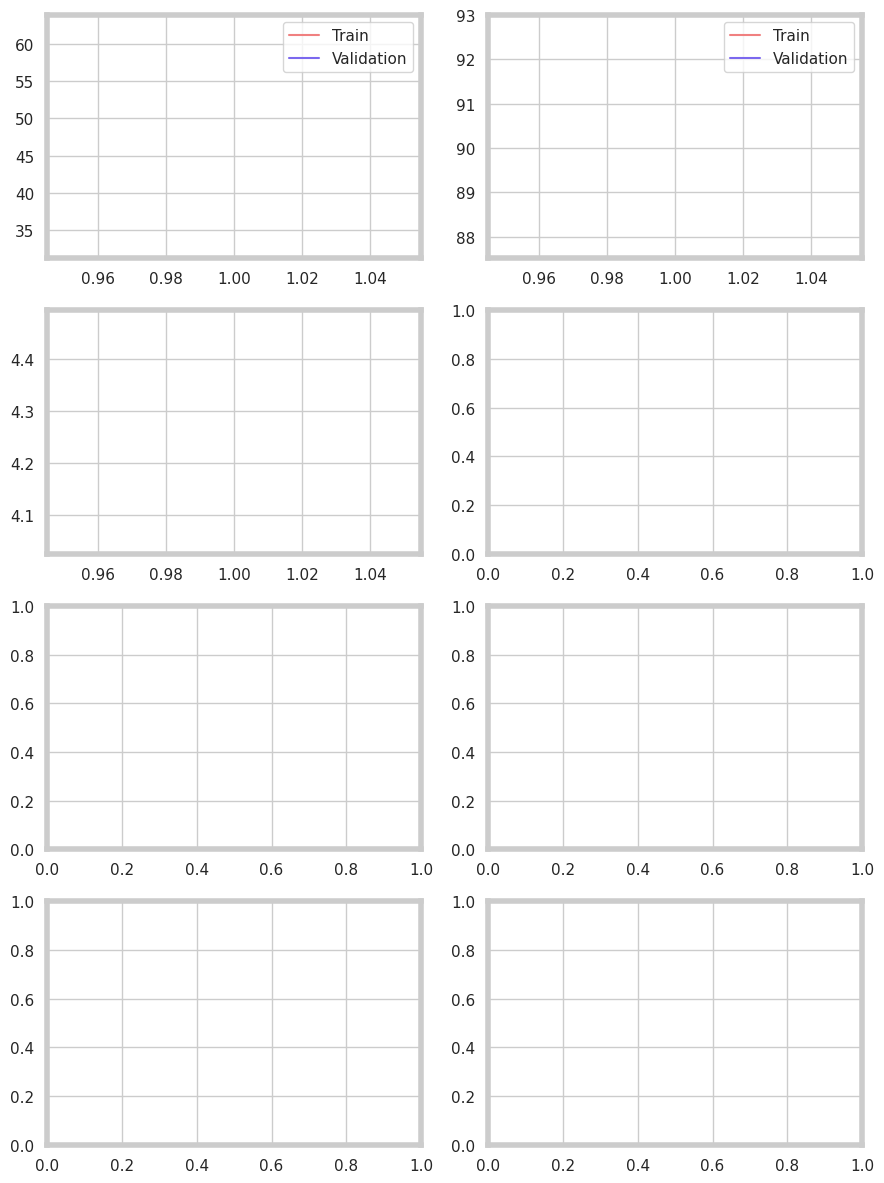

In [31]:
plot_title = today + '_results.png'

# if you want to save the plot
plot_results(marginalization_dict,num_epochs,save_title=plot_title)

# just display the plot
#plot_results(marginalization_dict,num_epochs)



In [51]:
mapping

{'CL:0000037': 0,
 'CL:0000038': 1,
 'CL:0000049': 2,
 'CL:0000050': 3,
 'CL:0000051': 4,
 'CL:0000081': 5,
 'CL:0000084': 6,
 'CL:0000091': 7,
 'CL:0000092': 8,
 'CL:0000094': 9,
 'CL:0000097': 10,
 'CL:0000129': 11,
 'CL:0000232': 12,
 'CL:0000233': 13,
 'CL:0000235': 14,
 'CL:0000236': 15,
 'CL:0000451': 16,
 'CL:0000453': 17,
 'CL:0000492': 18,
 'CL:0000542': 19,
 'CL:0000547': 20,
 'CL:0000556': 21,
 'CL:0000557': 22,
 'CL:0000559': 23,
 'CL:0000576': 24,
 'CL:0000583': 25,
 'CL:0000595': 26,
 'CL:0000623': 27,
 'CL:0000624': 28,
 'CL:0000625': 29,
 'CL:0000738': 30,
 'CL:0000763': 31,
 'CL:0000764': 32,
 'CL:0000765': 33,
 'CL:0000766': 34,
 'CL:0000767': 35,
 'CL:0000771': 36,
 'CL:0000775': 37,
 'CL:0000776': 38,
 'CL:0000782': 39,
 'CL:0000784': 40,
 'CL:0000785': 41,
 'CL:0000786': 42,
 'CL:0000787': 43,
 'CL:0000788': 44,
 'CL:0000789': 45,
 'CL:0000791': 46,
 'CL:0000794': 47,
 'CL:0000798': 48,
 'CL:0000800': 49,
 'CL:0000807': 50,
 'CL:0000808': 51,
 'CL:0000809': 52,
 'C

In [52]:
mapping_dict

{'CL:0000763': -9999,
 'CL:0000542': -9998,
 'CL:0000097': 0,
 'CL:0002046': 1,
 'CL:0000817': 2,
 'CL:0000051': 3,
 'CL:0000826': -9997,
 'CL:0001029': 4,
 'CL:0000990': -9996,
 'CL:0000785': -9995,
 'CL:0000816': 5,
 'CL:0000786': -9994,
 'CL:0000784': -9993,
 'CL:0000557': 6,
 'CL:0000084': -9992,
 'CL:0000814': -9991,
 'CL:0000837': -9990,
 'CL:0000037': 7,
 'CL:0000576': -9989,
 'CL:0000050': 8,
 'CL:0000129': 9,
 'CL:0000815': -9988,
 'CL:0000912': 10,
 'CL:0000940': 11,
 'CL:0000623': -9987,
 'CL:0000899': 12,
 'CL:0000798': -9986,
 'CL:0000235': -9985,
 'CL:0000775': -9984,
 'CL:0000236': -9983,
 'CL:0000453': 13,
 'CL:0002343': 14,
 'CL:0001078': 15,
 'CL:3000001': 16,
 'CL:0000451': -9982,
 'CL:0000094': -9981,
 'CL:0000738': -9980,
 'CL:0000878': -9979,
 'CL:0000972': -9978,
 'CL:0000788': 17,
 'CL:0000985': 18,
 'CL:0000987': 19,
 'CL:0000970': 20,
 'CL:0000913': 21,
 'CL:0000492': -9977,
 'CL:0000624': -9976,
 'CL:0000909': -9975,
 'CL:0000896': -9974,
 'CL:0000906': -9973

In [54]:
encoding_mapper

{-9999: 31,
 -9998: 19,
 0: 10,
 1: 124,
 2: 59,
 3: 4,
 -9997: 62,
 4: 107,
 -9996: 106,
 -9995: 41,
 5: 58,
 -9994: 42,
 -9993: 40,
 6: 22,
 -9992: 6,
 -9991: 56,
 -9990: 64,
 7: 0,
 -9989: 24,
 8: 3,
 9: 11,
 -9988: 57,
 10: 91,
 11: 99,
 -9987: 27,
 12: 81,
 -9986: 48,
 -9985: 14,
 -9984: 37,
 -9983: 15,
 13: 17,
 14: 127,
 15: 119,
 16: 142,
 -9982: 16,
 -9981: 9,
 -9980: 30,
 -9979: 73,
 -9978: 101,
 17: 44,
 18: 104,
 19: 105,
 20: 100,
 21: 92,
 -9977: 18,
 -9976: 28,
 -9975: 89,
 -9974: 78,
 -9973: 86,
 22: 85,
 23: 74,
 -9972: 69,
 -9971: 72,
 -9970: 39,
 24: 71,
 25: 35,
 26: 25,
 -9969: 29,
 -9968: 70,
 -9967: 140,
 27: 133,
 -9966: 118,
 -9965: 34,
 28: 33,
 -9964: 137,
 -9963: 80,
 -9962: 117,
 29: 83,
 -9961: 43,
 -9960: 55,
 -9959: 12,
 30: 90,
 -9958: 65,
 -9957: 66,
 31: 1,
 32: 20,
 33: 128,
 34: 123,
 35: 23,
 -9956: 112,
 36: 63,
 37: 21,
 38: 8,
 39: 97,
 40: 96,
 41: 2,
 42: 36,
 -9955: 134,
 -9954: 120,
 -9953: 136,
 43: 52,
 44: 135,
 45: 93,
 -9952: 79,
 -9951

In [48]:
cell_type_encoder.classes_

array(['CL:0000037', 'CL:0000038', 'CL:0000049', 'CL:0000050',
       'CL:0000051', 'CL:0000081', 'CL:0000084', 'CL:0000091',
       'CL:0000092', 'CL:0000094', 'CL:0000097', 'CL:0000129',
       'CL:0000232', 'CL:0000233', 'CL:0000235', 'CL:0000236',
       'CL:0000451', 'CL:0000453', 'CL:0000492', 'CL:0000542',
       'CL:0000547', 'CL:0000556', 'CL:0000557', 'CL:0000559',
       'CL:0000576', 'CL:0000583', 'CL:0000595', 'CL:0000623',
       'CL:0000624', 'CL:0000625', 'CL:0000738', 'CL:0000763',
       'CL:0000764', 'CL:0000765', 'CL:0000766', 'CL:0000767',
       'CL:0000771', 'CL:0000775', 'CL:0000776', 'CL:0000782',
       'CL:0000784', 'CL:0000785', 'CL:0000786', 'CL:0000787',
       'CL:0000788', 'CL:0000789', 'CL:0000791', 'CL:0000794',
       'CL:0000798', 'CL:0000800', 'CL:0000807', 'CL:0000808',
       'CL:0000809', 'CL:0000810', 'CL:0000811', 'CL:0000813',
       'CL:0000814', 'CL:0000815', 'CL:0000816', 'CL:0000817',
       'CL:0000818', 'CL:0000823', 'CL:0000826', 'CL:00

In [49]:
help(cell_type_encoder)

Help on LabelEncoder in module sklearn.preprocessing._label object:

class LabelEncoder(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  Encode target labels with value between 0 and n_classes-1.
 |  
 |  This transformer should be used to encode target values, *i.e.* `y`, and
 |  not the input `X`.
 |  
 |  Read more in the :ref:`User Guide <preprocessing_targets>`.
 |  
 |  .. versionadded:: 0.12
 |  
 |  Attributes
 |  ----------
 |  classes_ : ndarray of shape (n_classes,)
 |      Holds the label for each class.
 |  
 |  See Also
 |  --------
 |  OrdinalEncoder : Encode categorical features using an ordinal encoding
 |      scheme.
 |  OneHotEncoder : Encode categorical features as a one-hot numeric array.
 |  
 |  Examples
 |  --------
 |  `LabelEncoder` can be used to normalize labels.
 |  
 |  >>> from sklearn import preprocessing
 |  >>> le = preprocessing.LabelEncoder()
 |  >>> le.fit([1, 2, 2, 6])
 |  LabelEncoder()
 |  >>> le.classes_
 |  array([1, 2, 6])
 |  >

## From The CZI tutorial

In [9]:
experiment = census["census_data"]["homo_sapiens"]


In [19]:
experiment_datapipe = census_ml.ExperimentDataPipe(
    experiment,
    measurement_name="RNA",
    X_name="raw",
    obs_query=soma.AxisQuery(value_filter="tissue_general == 'tongue' and is_primary_data == True"),
    obs_column_names=["cell_type"],
    batch_size=128,
    shuffle=True,
    soma_chunk_size=10_000,
)


In [20]:
experiment_datapipe.shape

(15020, 60664)

In [12]:
train_datapipe, test_datapipe = experiment_datapipe.random_split(weights={"train": 0.8, "test": 0.2}, seed=1)


In [13]:
experiment_dataloader = census_ml.experiment_dataloader(train_datapipe)


In [15]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()  # noqa: UP008
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs


In [16]:
def train_epoch(model, train_dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        X_batch = X_batch.float().to(device)

        # Perform prediction
        outputs = model(X_batch)

        # Determine the predicted label
        probabilities = torch.nn.functional.softmax(outputs, 1)
        predictions = torch.argmax(probabilities, axis=1)

        # Compute the loss and perform back propagation

        # Exclude the cell_type labels, which are in the second column
        y_batch = y_batch[:, 1]
        y_batch = y_batch.to(device)

        train_correct += (predictions == y_batch).sum().item()
        train_total += len(predictions)

        loss = loss_fn(outputs, y_batch.long())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= train_total
    train_accuracy = train_correct / train_total
    return train_loss, train_accuracy


In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# The size of the input dimension is the number of genes
input_dim = experiment_datapipe.shape[1]

# The size of the output dimension is the number of distinct cell_type values
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type"]
output_dim = len(cell_type_encoder.classes_)

model = LogisticRegression(input_dim, output_dim).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-05)

for epoch in range(3):
    train_loss, train_accuracy = train_epoch(model, experiment_dataloader, loss_fn, optimizer, device)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.7f} Accuracy {train_accuracy:.4f}")


Epoch 1: Train Loss: 0.0185056 Accuracy 0.2145
Epoch 2: Train Loss: 0.0162072 Accuracy 0.2665
Epoch 3: Train Loss: 0.0149051 Accuracy 0.3136


In [19]:
experiment_dataloader = census_ml.experiment_dataloader(test_datapipe)
X_batch, y_batch = next(iter(experiment_dataloader))


In [20]:
model.eval()

model.to(device)
outputs = model(X_batch.to(device))

probabilities = torch.nn.functional.softmax(outputs, 1)
predictions = torch.argmax(probabilities, axis=1)

display(predictions)


tensor([1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1,
        7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 7, 1, 1, 1, 1, 1, 7,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 7, 7, 1, 1, 1, 1, 1])

In [3]:
census = cellxgene_census.open_soma(uri = "/scratch/welchjd_root/welchjd99/fujoshua/soma")

In [4]:
with cellxgene_census.open_soma(uri = "/scratch/welchjd_root/welchjd99/fujoshua/soma") as census:
    cell_metadata = census["census_data"]["homo_sapiens"].obs.read(
        value_filter = "sex == 'female' and cell_type in ['microglial cell', 'neuron']",
        column_names = ["assay", "cell_type", "tissue", "tissue_general", "suspension_type", "disease"]
    )


In [7]:
cell_metadata

In [ ]:
census

In [5]:
census["census_data"]["homo_sapiens"]

<Experiment 'file:///scratch/welchjd_root/welchjd99/fujoshua/soma/census_data/homo_sapiens' (CLOSED for 'r')>

In [6]:
census["census_data"]["homo_sapiens"].obs.read(
        value_filter = "sex == 'female' and cell_type in ['microglial cell', 'neuron']",
        column_names = ["assay", "cell_type", "tissue", "tissue_general", "suspension_type", "disease"]
    )

TileDBError: [TileDB::Array] Error: Cannot get array schema; Array is not open